# Imports

In [1]:
import pandas as pd
import numpy as np
import os, errno

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install orange3==3.33.0

In [4]:
#!pip install pandas==0.23.3

In [10]:
# COMENTAR from pandas.core.arrays.sparse.dtype import SparseDtype

import pandas as pd
#import pingouin as pg
from scipy.stats import friedmanchisquare, rankdata
from itertools import combinations
import numpy as np
from Orange.evaluation import graph_ranks,compute_CD
import matplotlib.pyplot as plt

In [11]:
SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 34

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
# plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=BIGGER_SIZE)     # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE, titleweight="bold")  # fontsize of the figure title
# plt.rc('lines', linewidth=2.6, markersize=16)

# TRAD

In [12]:
input_path ='/content/drive/MyDrive/Resultados/TRAD/tabelas/'
output_path ='/content/drive/MyDrive/Resultados/TRAD/tabelas/CD/'

## create dirs

In [13]:
 # cria dirrotio para keyphrase
try:
    os.makedirs(output_path)
except OSError as e:
    if e.errno != errno.EEXIST:
        raise

## load

In [14]:
df = pd.read_csv(input_path+"/mean/df_f1.csv", index_col='Dataframe')   # f1-score
df['average'] = df.mean(axis=1)

colunas = df.columns

In [15]:
colunas

Index(['1', '5', '10', '20', '30', 'average'], dtype='object')

## preprocess data

In [16]:
# Renomeas os "_" dos datasets por "-"
for idx, row in df.iterrows():
    x = idx.split('_')
    if len(x)==4:
        df.rename(index={idx: x[0]+'-'+x[1]+'_'+x[2]+'_'+x[3]},inplace=True)

df.fillna(0,inplace=True)

In [17]:
x = df.index.str.split('_', expand=True)

l1,l2,l3 = [], [], []
for i in x:
    l1.append(i[0])
    l2.append(i[1])
    l3.append(i[2])

df['dataset'] = l1
df['keyphrase'] =l2
df['alg'] = l3

# df[['dataset','keyphrase','alg']]= df.index.str.split('_', expand=True)

In [18]:
df.index = df['dataset']
# df.drop(index='CSTR',axis=0, inplace=True)

In [19]:
df

,1,5,10,20,30,average,dataset,keyphrase,alg
dataset,,,,,,,,,
CSTR,0.580277,0.811999,0.836131,0.811409,0.000000,0.759954,CSTR,keyphrase23,GAT
CSTR,0.594979,0.794995,0.819313,0.801470,0.000000,0.752690,CSTR,keyphrase23,GCN
CSTR,0.535783,0.824261,0.847399,0.816010,0.000000,0.755863,CSTR,keyphrase2,GAT
CSTR,0.585179,0.796397,0.806770,0.803067,0.000000,0.747853,CSTR,keyphrase2,GCN
CSTR,0.543135,0.828019,0.833142,0.811387,0.000000,0.753921,CSTR,keyphrase3,GAT
...,...,...,...,...,...,...,...,...,...
webkb-parsed,0.115618,0.253510,0.269867,0.222162,0.318071,0.235846,webkb-parsed,keyphrase23,GCN
webkb-parsed,0.169443,0.314226,0.374042,0.413629,0.440611,0.342390,webkb-parsed,keyphrase2,GAT
webkb-parsed,0.134415,0.262501,0.242717,0.273766,0.221325,0.226945,webkb-parsed,keyphrase2,GCN


In [20]:
dts = set(df.dataset)
l_df = [df[df.dataset == d][df.columns[0:]] for d in dts]

In [21]:
l_df = [ df_cstr.pivot(index='dataset', columns=['keyphrase','alg']) for df_cstr in l_df ]

In [22]:
l_df2 = []
for df_cstr in l_df:
    df_cstr.columns = df_cstr.columns.to_flat_index()
    df_cstr = df_cstr.reset_index()
    l_df2.append(df_cstr)

In [23]:
df = pd.concat(l_df2)

In [24]:
df

,dataset,"(1, keyphrase23, GAT)","(1, keyphrase23, GCN)","(1, keyphrase2, GAT)","(1, keyphrase2, GCN)","(1, keyphrase3, GAT)","(1, keyphrase3, GCN)","(5, keyphrase23, GAT)","(5, keyphrase23, GCN)","(5, keyphrase2, GAT)",...,"(30, keyphrase2, GAT)","(30, keyphrase2, GCN)","(30, keyphrase3, GAT)","(30, keyphrase3, GCN)","(average, keyphrase23, GAT)","(average, keyphrase23, GCN)","(average, keyphrase2, GAT)","(average, keyphrase2, GCN)","(average, keyphrase3, GAT)","(average, keyphrase3, GCN)"
0,Dmoz-Health,0.459878,0.358780,0.468887,0.385395,0.474111,0.370443,0.713335,0.613943,0.713070,...,0.806303,0.778161,0.811370,0.794888,0.711160,0.649267,0.711359,0.659188,0.714391,0.661676
0,CSTR,0.580277,0.594979,0.535783,0.585179,0.543135,0.572927,0.811999,0.794995,0.824261,...,0.000000,0.000000,0.000000,0.000000,0.759954,0.752690,0.755863,0.747853,0.753921,0.749357
0,webkb-parsed,0.160109,0.115618,0.169443,0.134415,0.159577,0.148489,0.324313,0.253510,0.314226,...,0.440611,0.221325,0.446037,0.236768,0.342945,0.235846,0.342390,0.226945,0.344517,0.239840
0,Dmoz-Computers,0.260446,0.203425,0.261693,0.212185,0.275186,0.223115,0.499124,0.456255,0.489782,...,0.610628,0.579147,0.619260,0.600515,0.504964,0.469540,0.500980,0.464952,0.511481,0.480057
0,review-polarity,0.471561,0.443660,0.478251,0.443336,0.413404,0.404728,0.481587,0.439292,0.479187,...,0.565629,0.409442,0.568918,0.393330,0.512479,0.449442,0.511381,0.438433,0.500059,0.413603
0,Industry-Sector,0.122962,0.100006,0.134428,0.103484,0.125307,0.106986,0.310029,0.226118,0.296418,...,0.477241,0.243629,0.482703,0.312325,0.351448,0.256252,0.348463,0.216786,0.352268,0.231415
0,Dmoz-Sports,0.440220,0.320157,0.456894,0.338423,0.446402,0.325213,0.733991,0.654226,0.735594,...,0.823061,0.759801,0.827495,0.783837,0.714976,0.642899,0.719575,0.641980,0.721224,0.651728
0,SyskillWebert,0.635706,0.562830,0.654670,0.579502,0.581477,0.553472,0.846864,0.752773,0.855654,...,0.904416,0.849886,0.902582,0.863715,0.833757,0.769162,0.842369,0.773423,0.823554,0.761887
0,re8,0.519853,0.423130,0.512416,0.435972,0.535774,0.475005,0.750288,0.691485,0.733904,...,0.812926,0.706982,0.818452,0.720514,0.745540,0.675240,0.734324,0.636690,0.750401,0.664044
0,classic4,0.761219,0.657634,0.770798,0.726874,0.795576,0.686328,0.886558,0.797807,0.895997,...,0.939366,0.928469,0.941874,0.924259,0.889393,0.834184,0.894367,0.860170,0.898463,0.850265


## Aply on all n_labels

1
('1', 'keyphrase23', 'GAT') average rank: 2.5833333333333335
('1', 'keyphrase23', 'GCN') average rank: 5.083333333333333
('1', 'keyphrase2', 'GAT') average rank: 2.0833333333333335
('1', 'keyphrase2', 'GCN') average rank: 4.416666666666667
('1', 'keyphrase3', 'GAT') average rank: 2.1666666666666665
('1', 'keyphrase3', 'GCN') average rank: 4.666666666666667


<ipython-input-25-401662576cf7>:21: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = compute_CD(avg_ranks, n=len(df_aux), alpha='0.1', test='nemenyi')
<ipython-input-25-401662576cf7>:24: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  graph_ranks(avg_ranks, names=algorithms_names, cd=cd, width=10, textspace=1.5, reverse=True)


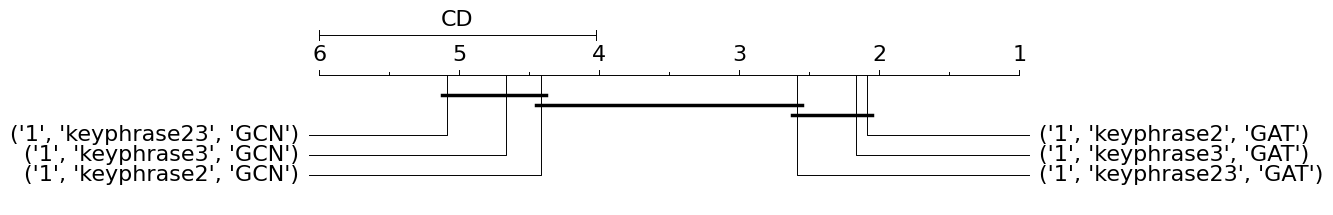

5
('5', 'keyphrase23', 'GAT') average rank: 2.3333333333333335
('5', 'keyphrase23', 'GCN') average rank: 5.083333333333333
('5', 'keyphrase2', 'GAT') average rank: 2.25
('5', 'keyphrase2', 'GCN') average rank: 5.166666666666667
('5', 'keyphrase3', 'GAT') average rank: 1.5
('5', 'keyphrase3', 'GCN') average rank: 4.666666666666667


<ipython-input-25-401662576cf7>:21: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = compute_CD(avg_ranks, n=len(df_aux), alpha='0.1', test='nemenyi')
<ipython-input-25-401662576cf7>:24: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  graph_ranks(avg_ranks, names=algorithms_names, cd=cd, width=10, textspace=1.5, reverse=True)


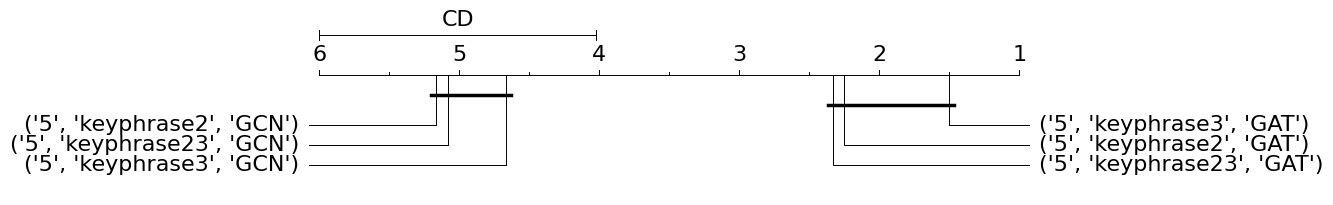

10
('10', 'keyphrase23', 'GAT') average rank: 2.25
('10', 'keyphrase23', 'GCN') average rank: 4.666666666666667
('10', 'keyphrase2', 'GAT') average rank: 2.1666666666666665
('10', 'keyphrase2', 'GCN') average rank: 5.416666666666667
('10', 'keyphrase3', 'GAT') average rank: 1.5833333333333333
('10', 'keyphrase3', 'GCN') average rank: 4.916666666666667


<ipython-input-25-401662576cf7>:21: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = compute_CD(avg_ranks, n=len(df_aux), alpha='0.1', test='nemenyi')
<ipython-input-25-401662576cf7>:24: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  graph_ranks(avg_ranks, names=algorithms_names, cd=cd, width=10, textspace=1.5, reverse=True)


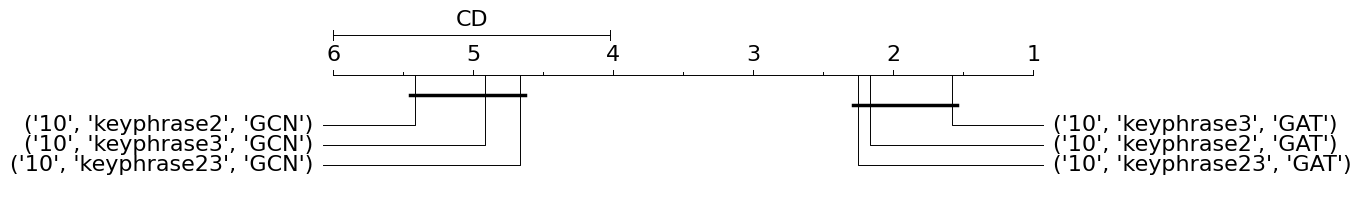

20
('20', 'keyphrase23', 'GAT') average rank: 2.0833333333333335
('20', 'keyphrase23', 'GCN') average rank: 5.0
('20', 'keyphrase2', 'GAT') average rank: 2.4166666666666665
('20', 'keyphrase2', 'GCN') average rank: 5.333333333333333
('20', 'keyphrase3', 'GAT') average rank: 1.5
('20', 'keyphrase3', 'GCN') average rank: 4.666666666666667


<ipython-input-25-401662576cf7>:21: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = compute_CD(avg_ranks, n=len(df_aux), alpha='0.1', test='nemenyi')
<ipython-input-25-401662576cf7>:24: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  graph_ranks(avg_ranks, names=algorithms_names, cd=cd, width=10, textspace=1.5, reverse=True)


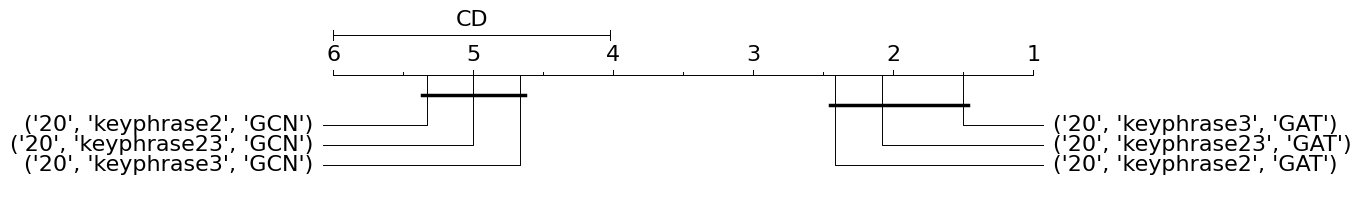

30
('30', 'keyphrase23', 'GAT') average rank: 2.125
('30', 'keyphrase23', 'GCN') average rank: 4.541666666666667
('30', 'keyphrase2', 'GAT') average rank: 2.7916666666666665
('30', 'keyphrase2', 'GCN') average rank: 5.458333333333333
('30', 'keyphrase3', 'GAT') average rank: 1.4583333333333333
('30', 'keyphrase3', 'GCN') average rank: 4.625


<ipython-input-25-401662576cf7>:21: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = compute_CD(avg_ranks, n=len(df_aux), alpha='0.1', test='nemenyi')
<ipython-input-25-401662576cf7>:24: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  graph_ranks(avg_ranks, names=algorithms_names, cd=cd, width=10, textspace=1.5, reverse=True)


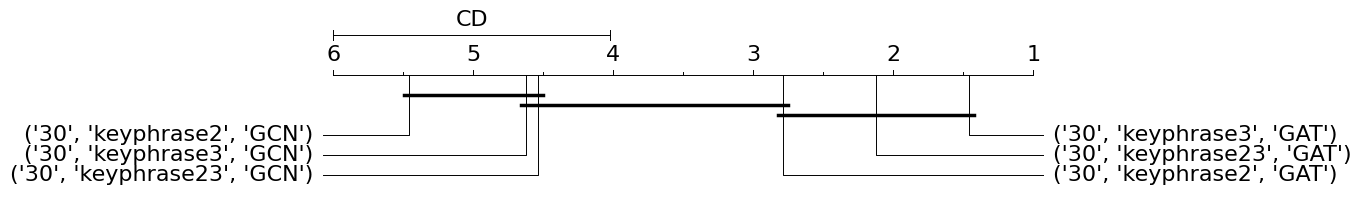

average
('average', 'keyphrase23', 'GAT') average rank: 2.1666666666666665
('average', 'keyphrase23', 'GCN') average rank: 4.75
('average', 'keyphrase2', 'GAT') average rank: 2.3333333333333335
('average', 'keyphrase2', 'GCN') average rank: 5.5
('average', 'keyphrase3', 'GAT') average rank: 1.5
('average', 'keyphrase3', 'GCN') average rank: 4.75


<ipython-input-25-401662576cf7>:21: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = compute_CD(avg_ranks, n=len(df_aux), alpha='0.1', test='nemenyi')
<ipython-input-25-401662576cf7>:24: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  graph_ranks(avg_ranks, names=algorithms_names, cd=cd, width=10, textspace=1.5, reverse=True)


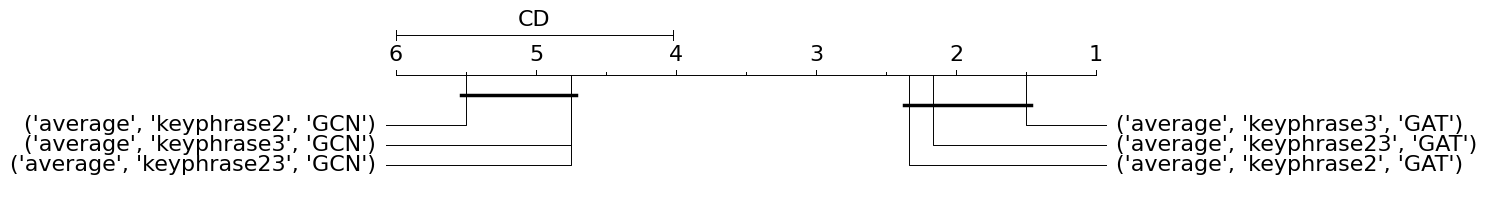

In [25]:
for nlabel in colunas:
    print(nlabel)

    columns = ['dataset']
    for col in df.columns[1:]:
        if col[0] == nlabel:
            columns.append(col)
    df_aux = df[columns]

    algorithms_names = df_aux.drop('dataset', axis=1).columns

    A = df_aux[algorithms_names].values

    friedmanchisquare(*A)

    ranks = np.array([rankdata(-p) for p in A])
    avg_ranks = np.mean(ranks, axis=0)

    print('\n'.join('{} average rank: {}'.format(a, r) for a, r in zip(algorithms_names, avg_ranks)))

    cd = compute_CD(avg_ranks, n=len(df_aux), alpha='0.1', test='nemenyi')

    # This method generates the plot.
    graph_ranks(avg_ranks, names=algorithms_names, cd=cd, width=10, textspace=1.5, reverse=True)
    plt.savefig(output_path+str(nlabel)+'.pdf', bbox_inches = "tight")
    plt.show()

    # bonferroni
    # cd = compute_CD(avg_ranks, n=len(df), alpha='0.05', test='bonferroni-dunn')

    # # This method generates the plot.
    # graph_ranks(avg_ranks, names=algorithms_names, cd=cd, cdmethod=0, width=10, textspace=1.5, reverse=True)
    # plt.show()

# TRAD - 80

In [26]:
input_path ='/content/drive/MyDrive/Resultados/TRAD/tabelas_80/'
output_path ='/content/drive/MyDrive/Resultados/TRAD/tabelas_80/CD/'

## create dirs

In [27]:
 # cria dirrotio para keyphrase
try:
    os.makedirs(output_path)
except OSError as e:
    if e.errno != errno.EEXIST:
        raise

## load

In [28]:
df = pd.read_csv(input_path+"mean/df_f1.csv", index_col='Dataframe')   # f1-score
df['average'] = df.mean(axis=1)

colunas = df.columns

In [29]:
colunas

Index(['1', '5', '10', '20', '30', '80%', 'average'], dtype='object')

## preprocess data

In [30]:
# Renomeas os "_" dos datasets por "-"
for idx, row in df.iterrows():
    x = idx.split('_')
    if len(x)==4:
        df.rename(index={idx: x[0]+'-'+x[1]+'_'+x[2]+'_'+x[3]},inplace=True)

df.fillna(0,inplace=True)

In [31]:
x = df.index.str.split('_', expand=True)

l1,l2,l3 = [], [], []
for i in x:
    l1.append(i[0])
    l2.append(i[1])
    l3.append(i[2])

df['dataset'] = l1
df['keyphrase'] =l2
df['alg'] = l3

# df[['dataset','keyphrase','alg']]= df.index.str.split('_', expand=True)

In [32]:
df.index = df['dataset']
# df.drop(index='CSTR',axis=0, inplace=True)

In [33]:
df

,1,5,10,20,30,80%,average,dataset,keyphrase,alg
dataset,,,,,,,,,,
CSTR,0.580277,0.811999,0.836131,0.811409,0.000000,0.868655,0.781694,CSTR,keyphrase23,GAT
CSTR,0.594979,0.794995,0.819313,0.801470,0.000000,0.867093,0.775570,CSTR,keyphrase23,GCN
CSTR,0.535783,0.824261,0.847399,0.816010,0.000000,0.870339,0.778758,CSTR,keyphrase2,GAT
CSTR,0.585179,0.796397,0.806770,0.803067,0.000000,0.869315,0.772146,CSTR,keyphrase2,GCN
CSTR,0.543135,0.828019,0.833142,0.811387,0.000000,0.872171,0.777571,CSTR,keyphrase3,GAT
...,...,...,...,...,...,...,...,...,...,...
webkb-parsed,0.115618,0.253510,0.269867,0.222162,0.318071,0.195496,0.229121,webkb-parsed,keyphrase23,GCN
webkb-parsed,0.169443,0.314226,0.374042,0.413629,0.440611,0.588644,0.383432,webkb-parsed,keyphrase2,GAT
webkb-parsed,0.134415,0.262501,0.242717,0.273766,0.221325,0.194150,0.221479,webkb-parsed,keyphrase2,GCN


In [34]:
dts = set(df.dataset)
l_df = [df[df.dataset == d][df.columns[0:]] for d in dts]

In [35]:
l_df = [ df_cstr.pivot(index='dataset', columns=['keyphrase','alg']) for df_cstr in l_df ]

In [36]:
l_df2 = []
for df_cstr in l_df:
    df_cstr.columns = df_cstr.columns.to_flat_index()
    df_cstr = df_cstr.reset_index()
    l_df2.append(df_cstr)

In [37]:
df = pd.concat(l_df2)

## Aply on all n_labels

1
('1', 'keyphrase23', 'GAT') average rank: 2.5833333333333335
('1', 'keyphrase23', 'GCN') average rank: 5.083333333333333
('1', 'keyphrase2', 'GAT') average rank: 2.0833333333333335
('1', 'keyphrase2', 'GCN') average rank: 4.416666666666667
('1', 'keyphrase3', 'GAT') average rank: 2.1666666666666665
('1', 'keyphrase3', 'GCN') average rank: 4.666666666666667


<ipython-input-38-401662576cf7>:21: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = compute_CD(avg_ranks, n=len(df_aux), alpha='0.1', test='nemenyi')
<ipython-input-38-401662576cf7>:24: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  graph_ranks(avg_ranks, names=algorithms_names, cd=cd, width=10, textspace=1.5, reverse=True)


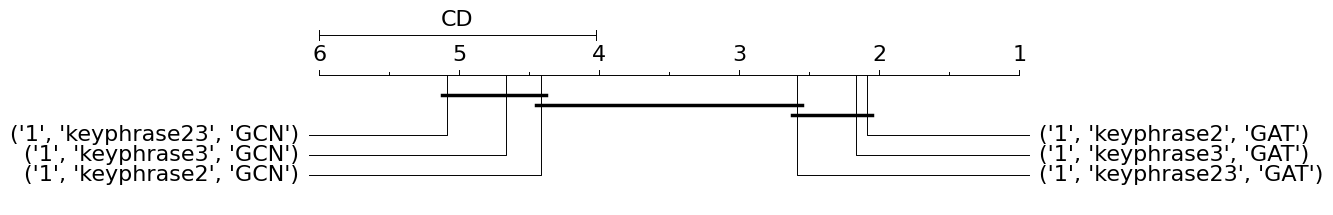

5
('5', 'keyphrase23', 'GAT') average rank: 2.3333333333333335
('5', 'keyphrase23', 'GCN') average rank: 5.083333333333333
('5', 'keyphrase2', 'GAT') average rank: 2.25
('5', 'keyphrase2', 'GCN') average rank: 5.166666666666667
('5', 'keyphrase3', 'GAT') average rank: 1.5
('5', 'keyphrase3', 'GCN') average rank: 4.666666666666667


<ipython-input-38-401662576cf7>:21: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = compute_CD(avg_ranks, n=len(df_aux), alpha='0.1', test='nemenyi')
<ipython-input-38-401662576cf7>:24: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  graph_ranks(avg_ranks, names=algorithms_names, cd=cd, width=10, textspace=1.5, reverse=True)


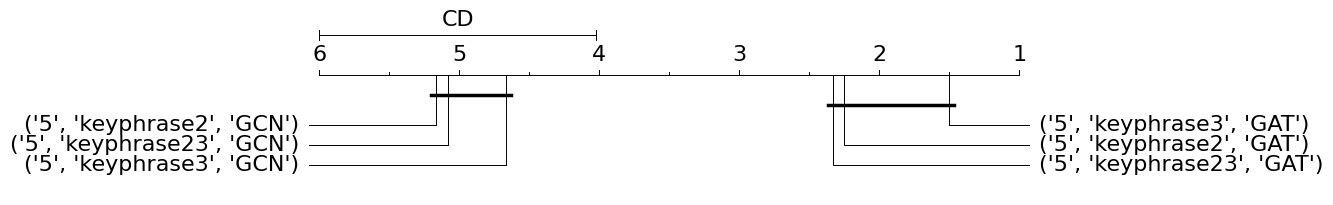

10
('10', 'keyphrase23', 'GAT') average rank: 2.25
('10', 'keyphrase23', 'GCN') average rank: 4.666666666666667
('10', 'keyphrase2', 'GAT') average rank: 2.1666666666666665
('10', 'keyphrase2', 'GCN') average rank: 5.416666666666667
('10', 'keyphrase3', 'GAT') average rank: 1.5833333333333333
('10', 'keyphrase3', 'GCN') average rank: 4.916666666666667


<ipython-input-38-401662576cf7>:21: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = compute_CD(avg_ranks, n=len(df_aux), alpha='0.1', test='nemenyi')
<ipython-input-38-401662576cf7>:24: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  graph_ranks(avg_ranks, names=algorithms_names, cd=cd, width=10, textspace=1.5, reverse=True)


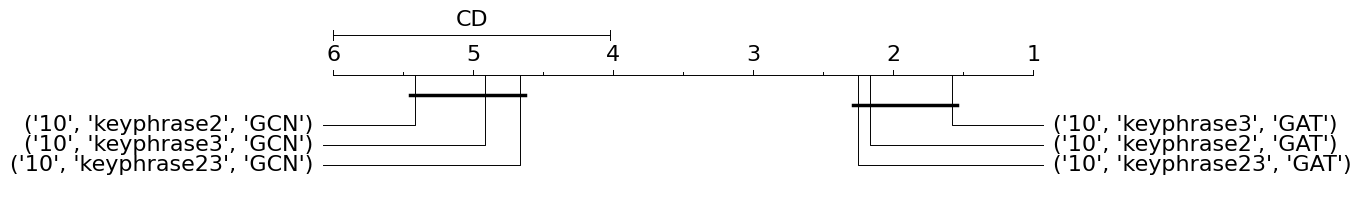

20
('20', 'keyphrase23', 'GAT') average rank: 2.0833333333333335
('20', 'keyphrase23', 'GCN') average rank: 5.0
('20', 'keyphrase2', 'GAT') average rank: 2.4166666666666665
('20', 'keyphrase2', 'GCN') average rank: 5.333333333333333
('20', 'keyphrase3', 'GAT') average rank: 1.5
('20', 'keyphrase3', 'GCN') average rank: 4.666666666666667


<ipython-input-38-401662576cf7>:21: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = compute_CD(avg_ranks, n=len(df_aux), alpha='0.1', test='nemenyi')
<ipython-input-38-401662576cf7>:24: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  graph_ranks(avg_ranks, names=algorithms_names, cd=cd, width=10, textspace=1.5, reverse=True)


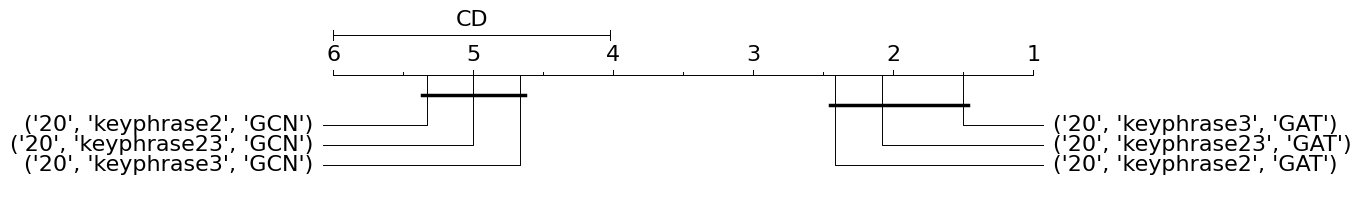

30
('30', 'keyphrase23', 'GAT') average rank: 2.125
('30', 'keyphrase23', 'GCN') average rank: 4.541666666666667
('30', 'keyphrase2', 'GAT') average rank: 2.7916666666666665
('30', 'keyphrase2', 'GCN') average rank: 5.458333333333333
('30', 'keyphrase3', 'GAT') average rank: 1.4583333333333333
('30', 'keyphrase3', 'GCN') average rank: 4.625


<ipython-input-38-401662576cf7>:21: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = compute_CD(avg_ranks, n=len(df_aux), alpha='0.1', test='nemenyi')
<ipython-input-38-401662576cf7>:24: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  graph_ranks(avg_ranks, names=algorithms_names, cd=cd, width=10, textspace=1.5, reverse=True)


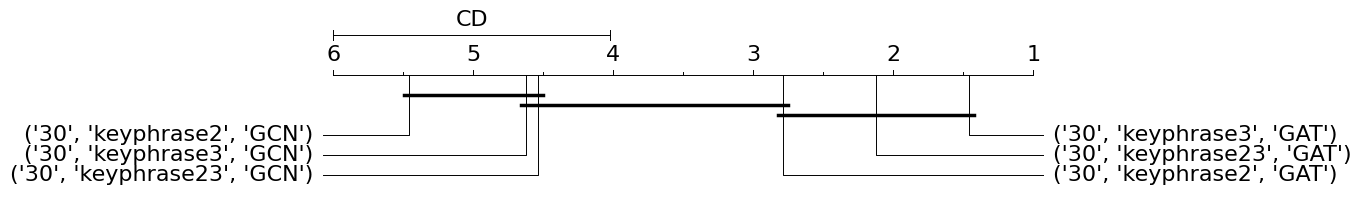

80%
('80%', 'keyphrase23', 'GAT') average rank: 2.6666666666666665
('80%', 'keyphrase23', 'GCN') average rank: 4.416666666666667
('80%', 'keyphrase2', 'GAT') average rank: 2.5833333333333335
('80%', 'keyphrase2', 'GCN') average rank: 5.416666666666667
('80%', 'keyphrase3', 'GAT') average rank: 2.0833333333333335
('80%', 'keyphrase3', 'GCN') average rank: 3.8333333333333335


<ipython-input-38-401662576cf7>:21: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = compute_CD(avg_ranks, n=len(df_aux), alpha='0.1', test='nemenyi')
<ipython-input-38-401662576cf7>:24: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  graph_ranks(avg_ranks, names=algorithms_names, cd=cd, width=10, textspace=1.5, reverse=True)


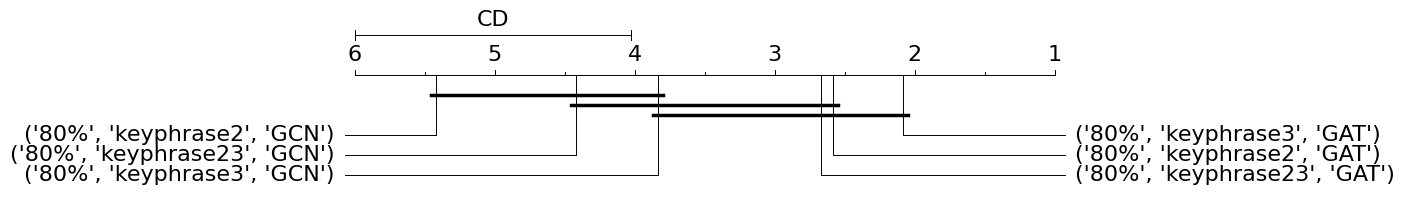

average
('average', 'keyphrase23', 'GAT') average rank: 2.25
('average', 'keyphrase23', 'GCN') average rank: 4.833333333333333
('average', 'keyphrase2', 'GAT') average rank: 2.25
('average', 'keyphrase2', 'GCN') average rank: 5.5
('average', 'keyphrase3', 'GAT') average rank: 1.5
('average', 'keyphrase3', 'GCN') average rank: 4.666666666666667


<ipython-input-38-401662576cf7>:21: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = compute_CD(avg_ranks, n=len(df_aux), alpha='0.1', test='nemenyi')
<ipython-input-38-401662576cf7>:24: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  graph_ranks(avg_ranks, names=algorithms_names, cd=cd, width=10, textspace=1.5, reverse=True)


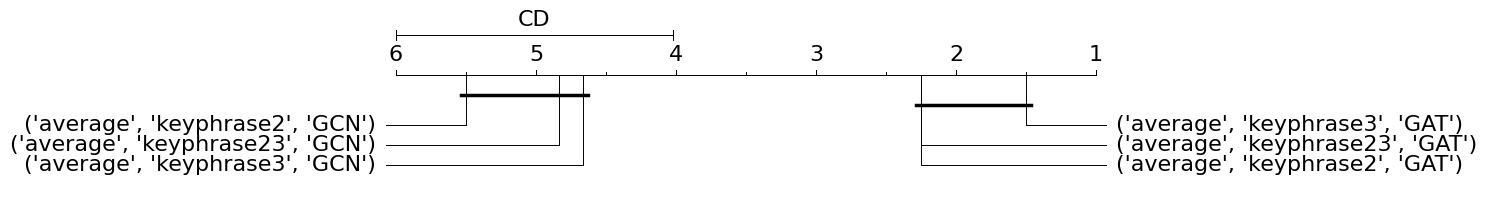

In [38]:
for nlabel in colunas:
    print(nlabel)

    columns = ['dataset']
    for col in df.columns[1:]:
        if col[0] == nlabel:
            columns.append(col)
    df_aux = df[columns]

    algorithms_names = df_aux.drop('dataset', axis=1).columns

    A = df_aux[algorithms_names].values

    friedmanchisquare(*A)

    ranks = np.array([rankdata(-p) for p in A])
    avg_ranks = np.mean(ranks, axis=0)

    print('\n'.join('{} average rank: {}'.format(a, r) for a, r in zip(algorithms_names, avg_ranks)))

    cd = compute_CD(avg_ranks, n=len(df_aux), alpha='0.1', test='nemenyi')

    # This method generates the plot.
    graph_ranks(avg_ranks, names=algorithms_names, cd=cd, width=10, textspace=1.5, reverse=True)
    plt.savefig(output_path+str(nlabel)+'.pdf', bbox_inches = "tight")
    plt.show()

    # bonferroni
    # cd = compute_CD(avg_ranks, n=len(df), alpha='0.05', test='bonferroni-dunn')

    # # This method generates the plot.
    # graph_ranks(avg_ranks, names=algorithms_names, cd=cd, cdmethod=0, width=10, textspace=1.5, reverse=True)
    # plt.show()

# TRAD_PERCENT - 80 60 40 20

In [39]:
input_path ='/content/drive/MyDrive/Resultados/TRAD_PERCENT/tabelas/'
output_path ='/content/drive/MyDrive/Resultados/TRAD_PERCENT/tabelas/CD/'

## create dirs

In [40]:
 # cria dirrotio para keyphrase
try:
    os.makedirs(output_path)
except OSError as e:
    if e.errno != errno.EEXIST:
        raise

## load

In [41]:
df = pd.read_csv(input_path+"/mean/df_f1.csv", index_col='Dataframe')   # f1-score
df['average'] = df.mean(axis=1)

colunas = df.columns

In [42]:
colunas

Index(['1', '5', '10', '20', '30', '20%', '40%', '60%', '80%', 'average'], dtype='object')

## preprocess data

In [43]:
# Renomeas os "_" dos datasets por "-"
for idx, row in df.iterrows():
    x = idx.split('_')
    if len(x)==4:
        df.rename(index={idx: x[0]+'-'+x[1]+'_'+x[2]+'_'+x[3]},inplace=True)

df.fillna(0,inplace=True)

In [44]:
x = df.index.str.split('_', expand=True)

l1,l2,l3 = [], [], []
for i in x:
    l1.append(i[0])
    l2.append(i[1])
    l3.append(i[2])

df['dataset'] = l1
df['keyphrase'] =l2
df['alg'] = l3

# df[['dataset','keyphrase','alg']]= df.index.str.split('_', expand=True)

In [45]:
df.index = df['dataset']
# df.drop(index='CSTR',axis=0, inplace=True)

In [46]:
df

,1,5,10,20,30,20%,40%,60%,80%,average,dataset,keyphrase,alg
dataset,,,,,,,,,,,,,
CSTR,0.580277,0.811999,0.836131,0.811409,0.000000,0.881766,0.882038,0.891683,0.860117,0.819428,CSTR,keyphrase23,GAT
CSTR,0.594979,0.794995,0.819313,0.801470,0.000000,0.852544,0.867220,0.887438,0.863678,0.810205,CSTR,keyphrase23,GCN
CSTR,0.535783,0.824261,0.847399,0.816010,0.000000,0.876006,0.876564,0.883832,0.863216,0.815384,CSTR,keyphrase2,GAT
CSTR,0.585179,0.796397,0.806770,0.803067,0.000000,0.832757,0.859574,0.873246,0.828135,0.798141,CSTR,keyphrase2,GCN
CSTR,0.543135,0.828019,0.833142,0.811387,0.000000,0.861966,0.878804,0.890149,0.869460,0.814508,CSTR,keyphrase3,GAT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
webkb-parsed,0.115618,0.253510,0.269867,0.222162,0.318071,0.234502,0.229224,0.220206,0.162427,0.225065,webkb-parsed,keyphrase23,GCN
webkb-parsed,0.169443,0.314226,0.374042,0.413629,0.440611,0.575649,0.593344,0.589532,0.602976,0.452606,webkb-parsed,keyphrase2,GAT
webkb-parsed,0.134415,0.262501,0.242717,0.273766,0.221325,0.236893,0.215608,0.218636,0.162864,0.218747,webkb-parsed,keyphrase2,GCN


In [47]:
dts = set(df.dataset)
l_df = [df[df.dataset == d][df.columns[0:]] for d in dts]

In [48]:
l_df = [ df_cstr.pivot(index='dataset', columns=['keyphrase','alg']) for df_cstr in l_df ]

In [49]:
l_df2 = []
for df_cstr in l_df:
    df_cstr.columns = df_cstr.columns.to_flat_index()
    df_cstr = df_cstr.reset_index()
    l_df2.append(df_cstr)

In [50]:
df = pd.concat(l_df2)

## Aply on all n_labels

1
('1', 'keyphrase23', 'GAT') average rank: 2.5833333333333335
('1', 'keyphrase23', 'GCN') average rank: 5.083333333333333
('1', 'keyphrase2', 'GAT') average rank: 2.0833333333333335
('1', 'keyphrase2', 'GCN') average rank: 4.416666666666667
('1', 'keyphrase3', 'GAT') average rank: 2.1666666666666665
('1', 'keyphrase3', 'GCN') average rank: 4.666666666666667


<ipython-input-51-401662576cf7>:21: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = compute_CD(avg_ranks, n=len(df_aux), alpha='0.1', test='nemenyi')
<ipython-input-51-401662576cf7>:24: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  graph_ranks(avg_ranks, names=algorithms_names, cd=cd, width=10, textspace=1.5, reverse=True)


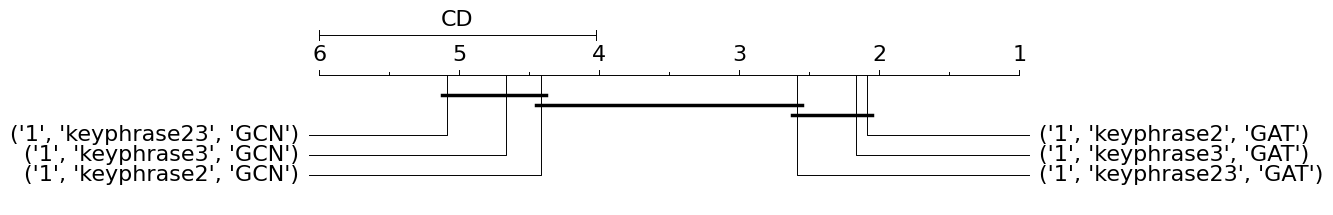

5
('5', 'keyphrase23', 'GAT') average rank: 2.3333333333333335
('5', 'keyphrase23', 'GCN') average rank: 5.083333333333333
('5', 'keyphrase2', 'GAT') average rank: 2.25
('5', 'keyphrase2', 'GCN') average rank: 5.166666666666667
('5', 'keyphrase3', 'GAT') average rank: 1.5
('5', 'keyphrase3', 'GCN') average rank: 4.666666666666667


<ipython-input-51-401662576cf7>:21: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = compute_CD(avg_ranks, n=len(df_aux), alpha='0.1', test='nemenyi')
<ipython-input-51-401662576cf7>:24: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  graph_ranks(avg_ranks, names=algorithms_names, cd=cd, width=10, textspace=1.5, reverse=True)


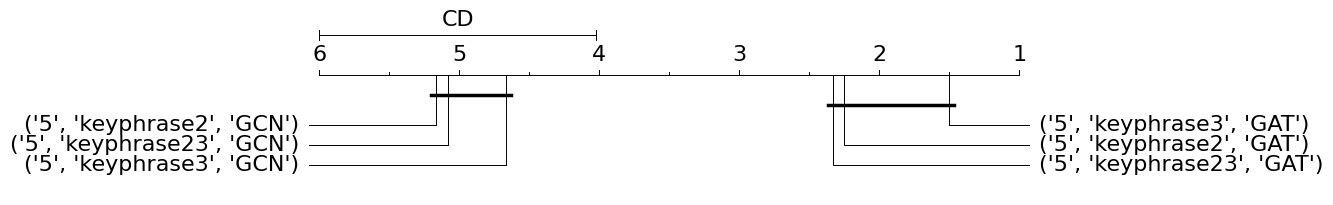

10
('10', 'keyphrase23', 'GAT') average rank: 2.25
('10', 'keyphrase23', 'GCN') average rank: 4.666666666666667
('10', 'keyphrase2', 'GAT') average rank: 2.1666666666666665
('10', 'keyphrase2', 'GCN') average rank: 5.416666666666667
('10', 'keyphrase3', 'GAT') average rank: 1.5833333333333333
('10', 'keyphrase3', 'GCN') average rank: 4.916666666666667


<ipython-input-51-401662576cf7>:21: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = compute_CD(avg_ranks, n=len(df_aux), alpha='0.1', test='nemenyi')
<ipython-input-51-401662576cf7>:24: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  graph_ranks(avg_ranks, names=algorithms_names, cd=cd, width=10, textspace=1.5, reverse=True)


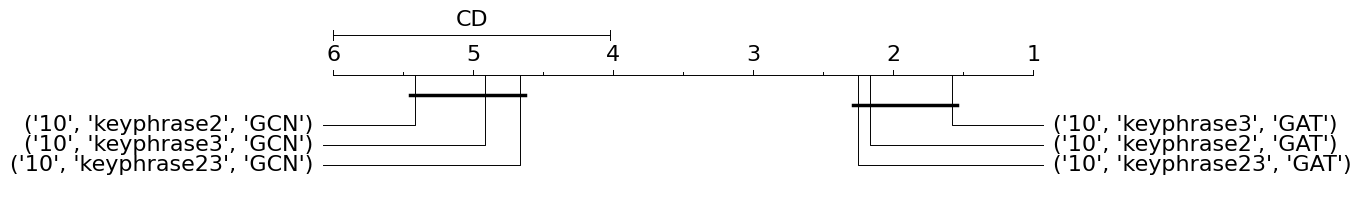

20
('20', 'keyphrase23', 'GAT') average rank: 2.0833333333333335
('20', 'keyphrase23', 'GCN') average rank: 5.0
('20', 'keyphrase2', 'GAT') average rank: 2.4166666666666665
('20', 'keyphrase2', 'GCN') average rank: 5.333333333333333
('20', 'keyphrase3', 'GAT') average rank: 1.5
('20', 'keyphrase3', 'GCN') average rank: 4.666666666666667


<ipython-input-51-401662576cf7>:21: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = compute_CD(avg_ranks, n=len(df_aux), alpha='0.1', test='nemenyi')
<ipython-input-51-401662576cf7>:24: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  graph_ranks(avg_ranks, names=algorithms_names, cd=cd, width=10, textspace=1.5, reverse=True)


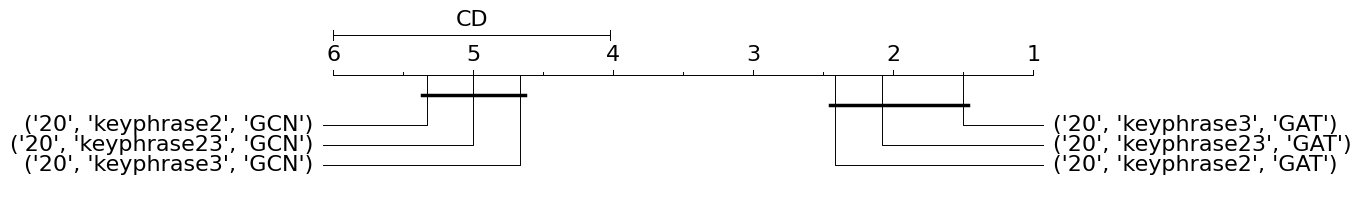

30
('30', 'keyphrase23', 'GAT') average rank: 2.125
('30', 'keyphrase23', 'GCN') average rank: 4.541666666666667
('30', 'keyphrase2', 'GAT') average rank: 2.7916666666666665
('30', 'keyphrase2', 'GCN') average rank: 5.458333333333333
('30', 'keyphrase3', 'GAT') average rank: 1.4583333333333333
('30', 'keyphrase3', 'GCN') average rank: 4.625


<ipython-input-51-401662576cf7>:21: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = compute_CD(avg_ranks, n=len(df_aux), alpha='0.1', test='nemenyi')
<ipython-input-51-401662576cf7>:24: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  graph_ranks(avg_ranks, names=algorithms_names, cd=cd, width=10, textspace=1.5, reverse=True)


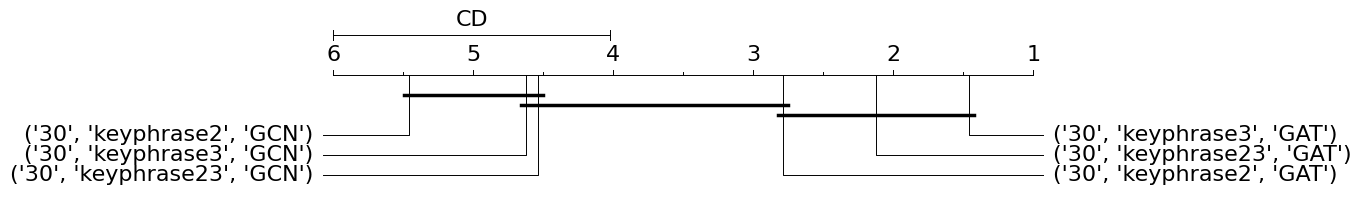

20%
('20%', 'keyphrase23', 'GAT') average rank: 1.9166666666666667
('20%', 'keyphrase23', 'GCN') average rank: 4.916666666666667
('20%', 'keyphrase2', 'GAT') average rank: 1.9166666666666667
('20%', 'keyphrase2', 'GCN') average rank: 5.666666666666667
('20%', 'keyphrase3', 'GAT') average rank: 2.25
('20%', 'keyphrase3', 'GCN') average rank: 4.333333333333333


<ipython-input-51-401662576cf7>:21: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = compute_CD(avg_ranks, n=len(df_aux), alpha='0.1', test='nemenyi')
<ipython-input-51-401662576cf7>:24: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  graph_ranks(avg_ranks, names=algorithms_names, cd=cd, width=10, textspace=1.5, reverse=True)


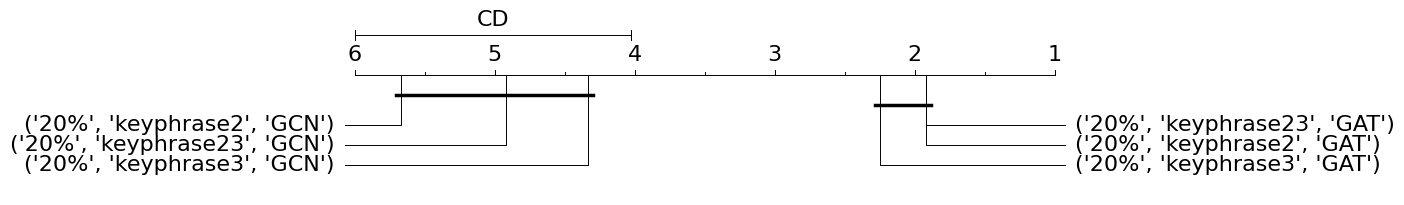

40%
('40%', 'keyphrase23', 'GAT') average rank: 2.3333333333333335
('40%', 'keyphrase23', 'GCN') average rank: 4.083333333333333
('40%', 'keyphrase2', 'GAT') average rank: 2.75
('40%', 'keyphrase2', 'GCN') average rank: 5.5
('40%', 'keyphrase3', 'GAT') average rank: 1.8333333333333333
('40%', 'keyphrase3', 'GCN') average rank: 4.5


<ipython-input-51-401662576cf7>:21: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = compute_CD(avg_ranks, n=len(df_aux), alpha='0.1', test='nemenyi')
<ipython-input-51-401662576cf7>:24: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  graph_ranks(avg_ranks, names=algorithms_names, cd=cd, width=10, textspace=1.5, reverse=True)


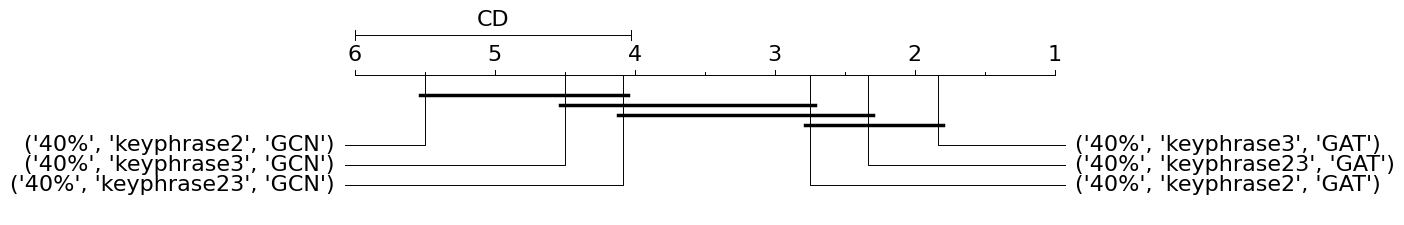

60%
('60%', 'keyphrase23', 'GAT') average rank: 2.0
('60%', 'keyphrase23', 'GCN') average rank: 4.25
('60%', 'keyphrase2', 'GAT') average rank: 3.0
('60%', 'keyphrase2', 'GCN') average rank: 5.333333333333333
('60%', 'keyphrase3', 'GAT') average rank: 2.0833333333333335
('60%', 'keyphrase3', 'GCN') average rank: 4.333333333333333


<ipython-input-51-401662576cf7>:21: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = compute_CD(avg_ranks, n=len(df_aux), alpha='0.1', test='nemenyi')
<ipython-input-51-401662576cf7>:24: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  graph_ranks(avg_ranks, names=algorithms_names, cd=cd, width=10, textspace=1.5, reverse=True)


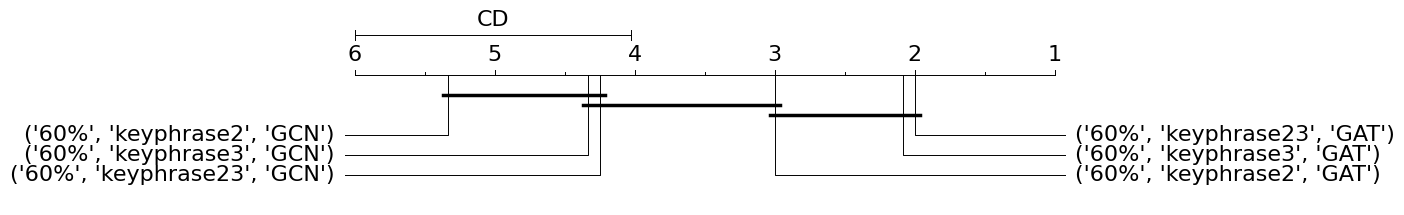

80%
('80%', 'keyphrase23', 'GAT') average rank: 2.6666666666666665
('80%', 'keyphrase23', 'GCN') average rank: 4.333333333333333
('80%', 'keyphrase2', 'GAT') average rank: 2.6666666666666665
('80%', 'keyphrase2', 'GCN') average rank: 4.833333333333333
('80%', 'keyphrase3', 'GAT') average rank: 2.25
('80%', 'keyphrase3', 'GCN') average rank: 4.25


<ipython-input-51-401662576cf7>:21: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = compute_CD(avg_ranks, n=len(df_aux), alpha='0.1', test='nemenyi')
<ipython-input-51-401662576cf7>:24: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  graph_ranks(avg_ranks, names=algorithms_names, cd=cd, width=10, textspace=1.5, reverse=True)


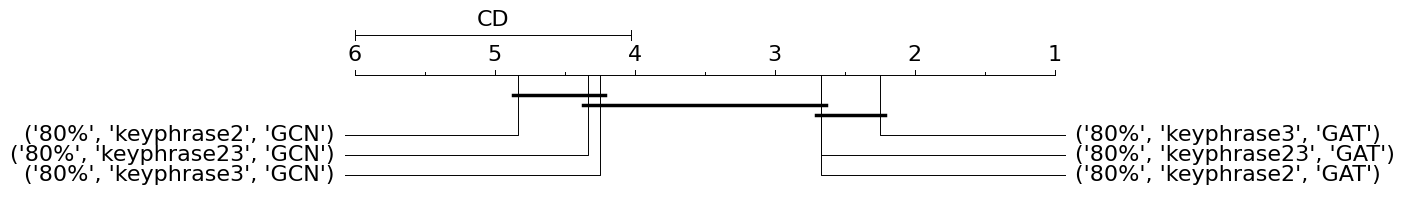

average
('average', 'keyphrase23', 'GAT') average rank: 2.1666666666666665
('average', 'keyphrase23', 'GCN') average rank: 4.833333333333333
('average', 'keyphrase2', 'GAT') average rank: 2.25
('average', 'keyphrase2', 'GCN') average rank: 5.5
('average', 'keyphrase3', 'GAT') average rank: 1.5833333333333333
('average', 'keyphrase3', 'GCN') average rank: 4.666666666666667


<ipython-input-51-401662576cf7>:21: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = compute_CD(avg_ranks, n=len(df_aux), alpha='0.1', test='nemenyi')
<ipython-input-51-401662576cf7>:24: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  graph_ranks(avg_ranks, names=algorithms_names, cd=cd, width=10, textspace=1.5, reverse=True)


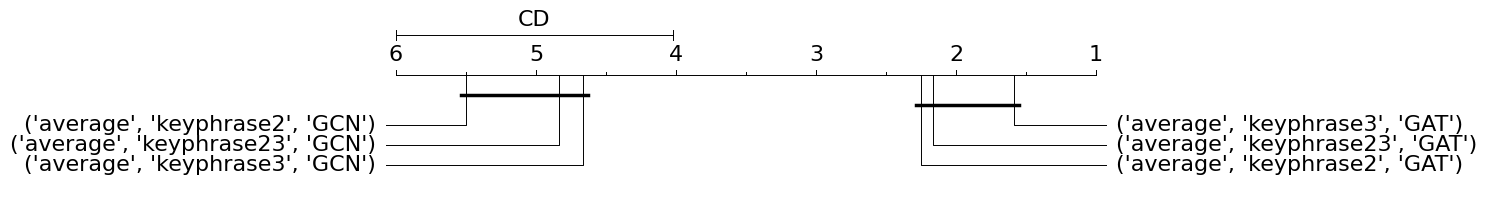

In [51]:
for nlabel in colunas:
    print(nlabel)

    columns = ['dataset']
    for col in df.columns[1:]:
        if col[0] == nlabel:
            columns.append(col)
    df_aux = df[columns]

    algorithms_names = df_aux.drop('dataset', axis=1).columns

    A = df_aux[algorithms_names].values

    friedmanchisquare(*A)

    ranks = np.array([rankdata(-p) for p in A])
    avg_ranks = np.mean(ranks, axis=0)

    print('\n'.join('{} average rank: {}'.format(a, r) for a, r in zip(algorithms_names, avg_ranks)))

    cd = compute_CD(avg_ranks, n=len(df_aux), alpha='0.1', test='nemenyi')

    # This method generates the plot.
    graph_ranks(avg_ranks, names=algorithms_names, cd=cd, width=10, textspace=1.5, reverse=True)
    plt.savefig(output_path+str(nlabel)+'.pdf', bbox_inches = "tight")
    plt.show()

    # bonferroni
    # cd = compute_CD(avg_ranks, n=len(df), alpha='0.05', test='bonferroni-dunn')

    # # This method generates the plot.
    # graph_ranks(avg_ranks, names=algorithms_names, cd=cd, cdmethod=0, width=10, textspace=1.5, reverse=True)
    # plt.show()

# COARSENING

In [52]:
input_path ='/content/drive/MyDrive/Resultados/COARSENING/tabelas/'
output_path ='/content/drive/MyDrive/Resultados/COARSENING/tabelas/CD/'

## create dirs

In [53]:
 # cria dirrotio para keyphrase
try:
    os.makedirs(output_path)
except OSError as e:
    if e.errno != errno.EEXIST:
        raise

## load

In [54]:
df = pd.read_csv(input_path+"/mean/df_f1.csv", index_col='Dataframe')   # f1-score
df['average'] = df.mean(axis=1)

colunas = df.columns

In [55]:
colunas

Index(['1', '5', '10', '20', '30', 'average'], dtype='object')

## preprocess data

In [56]:
# Renomeas os "_" dos datasets por "-"
for idx, row in df.iterrows():
    x = idx.split('_')
    if len(x)==4:
        df.rename(index={idx: x[0]+'-'+x[1]+'_'+x[2]+'_'+x[3]},inplace=True)

df.fillna(0,inplace=True)

In [57]:
x = df.index.str.split('_', expand=True)

l1,l2,l3 = [], [], []
for i in x:
    l1.append(i[0])
    l2.append(i[1])
    l3.append(i[2])

df['dataset'] = l1
df['keyphrase'] =l2
df['alg'] = l3

# df[['dataset','keyphrase','alg']]= df.index.str.split('_', expand=True)

In [58]:
df.index = df['dataset']
# df.drop(index='CSTR',axis=0, inplace=True)

In [59]:
df

,1,5,10,20,30,average,dataset,keyphrase,alg
dataset,,,,,,,,,
CSTR,0.449338,0.658859,0.692198,0.641874,0.000000,0.610567,CSTR,keyphrase23,GAT
CSTR,0.451129,0.665657,0.647688,0.630112,0.000000,0.598646,CSTR,keyphrase23,GCN
CSTR,0.413739,0.705777,0.655625,0.680776,0.000000,0.613979,CSTR,keyphrase2,GAT
CSTR,0.420849,0.646299,0.658193,0.614132,0.000000,0.584868,CSTR,keyphrase2,GCN
CSTR,0.489392,0.672212,0.603976,0.627418,0.000000,0.598249,CSTR,keyphrase3,GAT
...,...,...,...,...,...,...,...,...,...
webkb-parsed,0.092440,0.186741,0.205535,0.201542,0.215285,0.180308,webkb-parsed,keyphrase23,GCN
webkb-parsed,0.104692,0.231715,0.258802,0.283577,0.291179,0.233993,webkb-parsed,keyphrase2,GAT
webkb-parsed,0.082880,0.185896,0.230089,0.168714,0.261313,0.185778,webkb-parsed,keyphrase2,GCN


In [60]:
dts = set(df.dataset)
l_df = [df[df.dataset == d][df.columns[0:]] for d in dts]

In [61]:
l_df = [ df_cstr.pivot(index='dataset', columns=['keyphrase','alg']) for df_cstr in l_df ]

In [62]:
l_df2 = []
for df_cstr in l_df:
    df_cstr.columns = df_cstr.columns.to_flat_index()
    df_cstr = df_cstr.reset_index()
    l_df2.append(df_cstr)

In [63]:
df = pd.concat(l_df2)

## Aply on all n_labels

1
('1', 'keyphrase23', 'GAT') average rank: 2.0
('1', 'keyphrase23', 'GCN') average rank: 4.25
('1', 'keyphrase2', 'GAT') average rank: 3.0833333333333335
('1', 'keyphrase2', 'GCN') average rank: 5.333333333333333
('1', 'keyphrase3', 'GAT') average rank: 1.9583333333333333
('1', 'keyphrase3', 'GCN') average rank: 4.375


<ipython-input-64-401662576cf7>:21: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = compute_CD(avg_ranks, n=len(df_aux), alpha='0.1', test='nemenyi')
<ipython-input-64-401662576cf7>:24: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  graph_ranks(avg_ranks, names=algorithms_names, cd=cd, width=10, textspace=1.5, reverse=True)


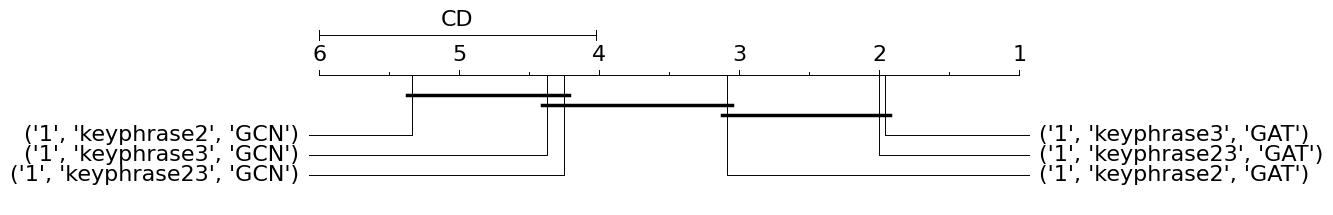

5
('5', 'keyphrase23', 'GAT') average rank: 1.9166666666666667
('5', 'keyphrase23', 'GCN') average rank: 3.9166666666666665
('5', 'keyphrase2', 'GAT') average rank: 3.5
('5', 'keyphrase2', 'GCN') average rank: 5.583333333333333
('5', 'keyphrase3', 'GAT') average rank: 2.0833333333333335
('5', 'keyphrase3', 'GCN') average rank: 4.0


<ipython-input-64-401662576cf7>:21: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = compute_CD(avg_ranks, n=len(df_aux), alpha='0.1', test='nemenyi')
<ipython-input-64-401662576cf7>:24: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  graph_ranks(avg_ranks, names=algorithms_names, cd=cd, width=10, textspace=1.5, reverse=True)


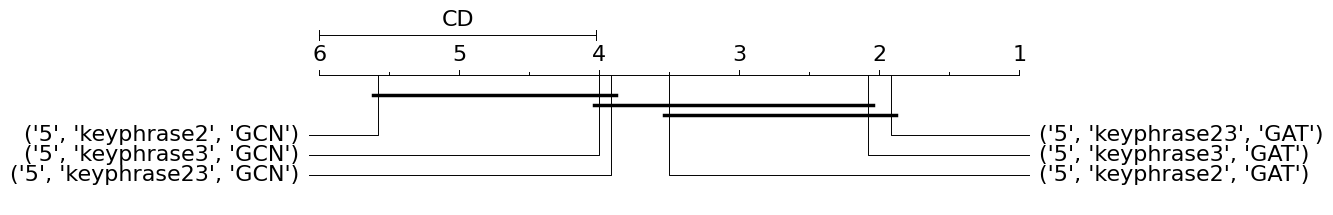

10
('10', 'keyphrase23', 'GAT') average rank: 2.0
('10', 'keyphrase23', 'GCN') average rank: 3.8333333333333335
('10', 'keyphrase2', 'GAT') average rank: 3.8333333333333335
('10', 'keyphrase2', 'GCN') average rank: 4.75
('10', 'keyphrase3', 'GAT') average rank: 2.4166666666666665
('10', 'keyphrase3', 'GCN') average rank: 4.166666666666667


<ipython-input-64-401662576cf7>:21: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = compute_CD(avg_ranks, n=len(df_aux), alpha='0.1', test='nemenyi')
<ipython-input-64-401662576cf7>:24: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  graph_ranks(avg_ranks, names=algorithms_names, cd=cd, width=10, textspace=1.5, reverse=True)


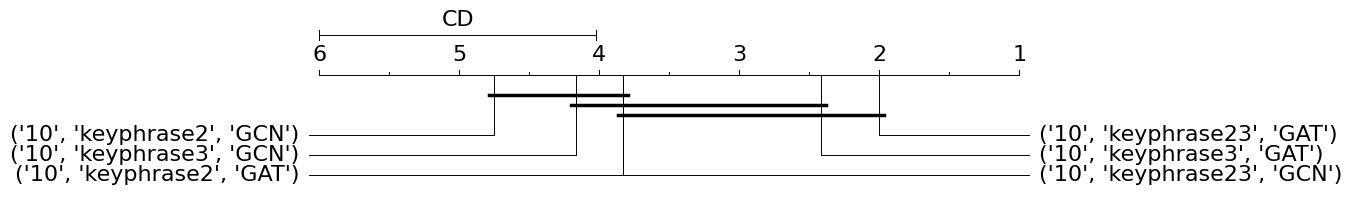

20
('20', 'keyphrase23', 'GAT') average rank: 2.0
('20', 'keyphrase23', 'GCN') average rank: 3.5833333333333335
('20', 'keyphrase2', 'GAT') average rank: 4.083333333333333
('20', 'keyphrase2', 'GCN') average rank: 5.333333333333333
('20', 'keyphrase3', 'GAT') average rank: 2.1666666666666665
('20', 'keyphrase3', 'GCN') average rank: 3.8333333333333335


<ipython-input-64-401662576cf7>:21: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = compute_CD(avg_ranks, n=len(df_aux), alpha='0.1', test='nemenyi')
<ipython-input-64-401662576cf7>:24: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  graph_ranks(avg_ranks, names=algorithms_names, cd=cd, width=10, textspace=1.5, reverse=True)


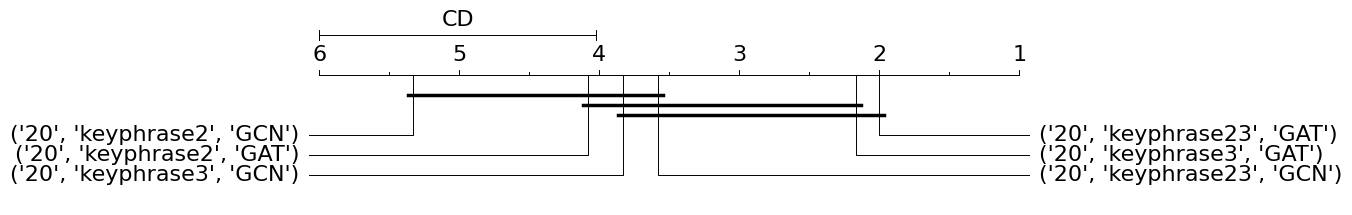

30
('30', 'keyphrase23', 'GAT') average rank: 1.7916666666666667
('30', 'keyphrase23', 'GCN') average rank: 3.5416666666666665
('30', 'keyphrase2', 'GAT') average rank: 4.375
('30', 'keyphrase2', 'GCN') average rank: 4.958333333333333
('30', 'keyphrase3', 'GAT') average rank: 2.375
('30', 'keyphrase3', 'GCN') average rank: 3.9583333333333335


<ipython-input-64-401662576cf7>:21: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = compute_CD(avg_ranks, n=len(df_aux), alpha='0.1', test='nemenyi')
<ipython-input-64-401662576cf7>:24: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  graph_ranks(avg_ranks, names=algorithms_names, cd=cd, width=10, textspace=1.5, reverse=True)


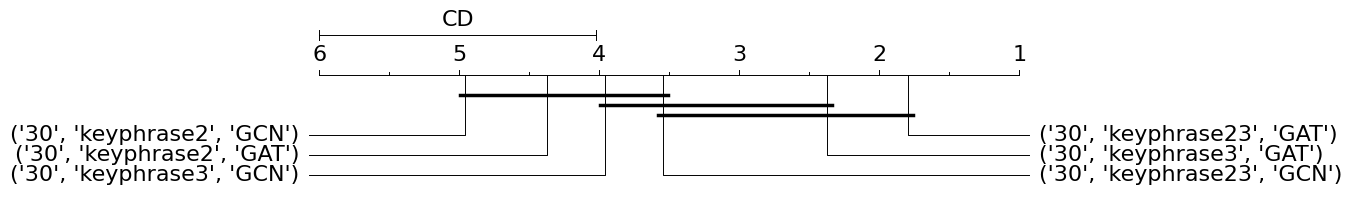

average
('average', 'keyphrase23', 'GAT') average rank: 1.5
('average', 'keyphrase23', 'GCN') average rank: 3.8333333333333335
('average', 'keyphrase2', 'GAT') average rank: 3.75
('average', 'keyphrase2', 'GCN') average rank: 5.416666666666667
('average', 'keyphrase3', 'GAT') average rank: 2.3333333333333335
('average', 'keyphrase3', 'GCN') average rank: 4.166666666666667


<ipython-input-64-401662576cf7>:21: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = compute_CD(avg_ranks, n=len(df_aux), alpha='0.1', test='nemenyi')
<ipython-input-64-401662576cf7>:24: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  graph_ranks(avg_ranks, names=algorithms_names, cd=cd, width=10, textspace=1.5, reverse=True)


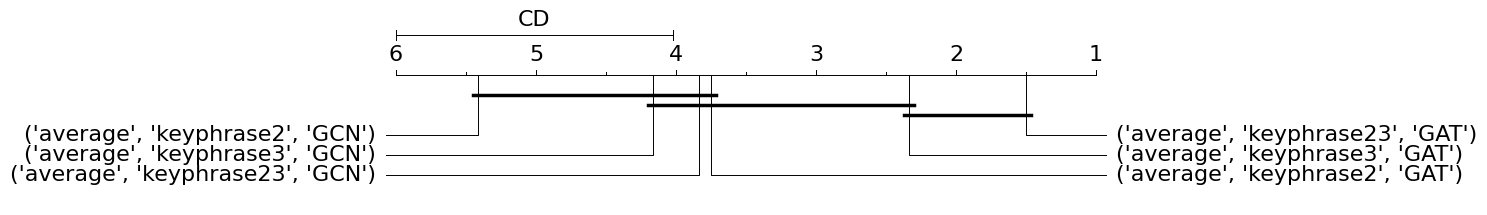

In [64]:
for nlabel in colunas:
    print(nlabel)

    columns = ['dataset']
    for col in df.columns[1:]:
        if col[0] == nlabel:
            columns.append(col)
    df_aux = df[columns]

    algorithms_names = df_aux.drop('dataset', axis=1).columns

    A = df_aux[algorithms_names].values

    friedmanchisquare(*A)

    ranks = np.array([rankdata(-p) for p in A])
    avg_ranks = np.mean(ranks, axis=0)

    print('\n'.join('{} average rank: {}'.format(a, r) for a, r in zip(algorithms_names, avg_ranks)))

    cd = compute_CD(avg_ranks, n=len(df_aux), alpha='0.1', test='nemenyi')

    # This method generates the plot.
    graph_ranks(avg_ranks, names=algorithms_names, cd=cd, width=10, textspace=1.5, reverse=True)
    plt.savefig(output_path+str(nlabel)+'.pdf', bbox_inches = "tight")
    plt.show()

    # bonferroni
    # cd = compute_CD(avg_ranks, n=len(df), alpha='0.05', test='bonferroni-dunn')

    # # This method generates the plot.
    # graph_ranks(avg_ranks, names=algorithms_names, cd=cd, cdmethod=0, width=10, textspace=1.5, reverse=True)
    # plt.show()

# LLM 10

In [65]:
# sample_size = 10
input_path ='/content/drive/MyDrive/Resultados/LLM/10/tabelas/'
output_path ='/content/drive/MyDrive/Resultados/LLM/10/tabelas/CD/'

## create dirs

In [66]:
 # cria dirrotio para keyphrase
try:
    os.makedirs(output_path)
except OSError as e:
    if e.errno != errno.EEXIST:
        raise

## load

In [67]:
df = pd.read_csv(input_path+"/mean/df_f1.csv", index_col='Dataframe')   # f1-score
df['average'] = df.mean(axis=1)

colunas = df.columns

In [68]:
colunas

Index(['LLM_only', '1', '5', '10', '20', '30', 'average'], dtype='object')

## preprocess data

In [69]:
# Renomeas os "_" dos datasets por "-"
for idx, row in df.iterrows():
    x = idx.split('_')
    if len(x)==4:
        df.rename(index={idx: x[0]+'-'+x[1]+'_'+x[2]+'_'+x[3]},inplace=True)

df.fillna(0,inplace=True)

In [70]:
x = df.index.str.split('_', expand=True)

l1,l2,l3 = [], [], []
for i in x:
    l1.append(i[0])
    l2.append(i[1])
    l3.append(i[2])

df['dataset'] = l1
df['keyphrase'] =l2
df['alg'] = l3

# df[['dataset','keyphrase','alg']]= df.index.str.split('_', expand=True)

In [71]:
df.index = df['dataset']
# df.drop(index='CSTR',axis=0, inplace=True)

In [72]:
df

,LLM_only,1,5,10,20,30,average,dataset,keyphrase,alg
dataset,,,,,,,,,,
CSTR,0.757546,0.758512,0.798584,0.769638,0.747737,0.000000,0.766403,CSTR,keyphrase23,GAT
CSTR,0.742776,0.748463,0.807345,0.734701,0.721207,0.000000,0.750899,CSTR,keyphrase23,GCN
CSTR,0.762490,0.771122,0.787401,0.785577,0.744569,0.000000,0.770232,CSTR,keyphrase2,GAT
CSTR,0.742948,0.744552,0.774179,0.759525,0.709890,0.000000,0.746219,CSTR,keyphrase2,GCN
CSTR,0.754462,0.767492,0.807455,0.772574,0.747777,0.000000,0.769952,CSTR,keyphrase3,GAT
...,...,...,...,...,...,...,...,...,...,...
webkb-parsed,0.212860,0.218984,0.244977,0.232784,0.225252,0.258436,0.232215,webkb-parsed,keyphrase23,GCN
webkb-parsed,0.255840,0.261126,0.306373,0.343035,0.385893,0.412372,0.327440,webkb-parsed,keyphrase2,GAT
webkb-parsed,0.219891,0.209725,0.222302,0.228333,0.223140,0.204287,0.217946,webkb-parsed,keyphrase2,GCN


In [73]:
dts = set(df.dataset)
l_df = [df[df.dataset == d][df.columns[0:]] for d in dts]

In [74]:
l_df = [ df_cstr.pivot(index='dataset', columns=['keyphrase','alg']) for df_cstr in l_df ]

In [75]:
l_df2 = []
for df_cstr in l_df:
    df_cstr.columns = df_cstr.columns.to_flat_index()
    df_cstr = df_cstr.reset_index()
    l_df2.append(df_cstr)

In [76]:
df = pd.concat(l_df2)

## Aply on all n_labels

LLM_only
('LLM_only', 'keyphrase23', 'GAT') average rank: 2.3333333333333335
('LLM_only', 'keyphrase23', 'GCN') average rank: 4.916666666666667
('LLM_only', 'keyphrase2', 'GAT') average rank: 2.1666666666666665
('LLM_only', 'keyphrase2', 'GCN') average rank: 5.166666666666667
('LLM_only', 'keyphrase3', 'GAT') average rank: 2.1666666666666665
('LLM_only', 'keyphrase3', 'GCN') average rank: 4.25


<ipython-input-77-401662576cf7>:21: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = compute_CD(avg_ranks, n=len(df_aux), alpha='0.1', test='nemenyi')
<ipython-input-77-401662576cf7>:24: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  graph_ranks(avg_ranks, names=algorithms_names, cd=cd, width=10, textspace=1.5, reverse=True)


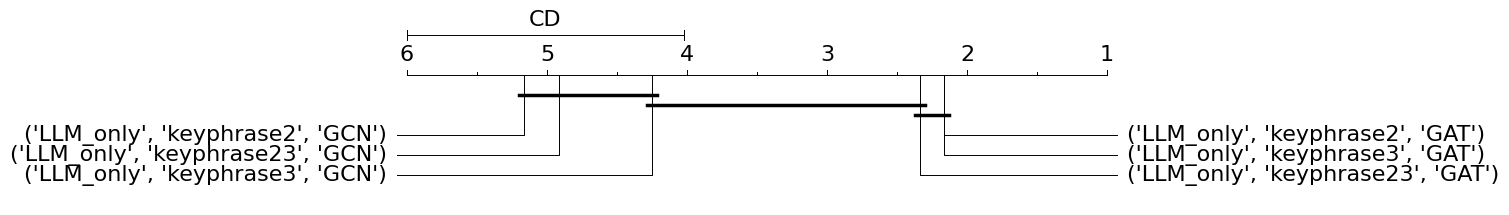

1
('1', 'keyphrase23', 'GAT') average rank: 2.3333333333333335
('1', 'keyphrase23', 'GCN') average rank: 4.75
('1', 'keyphrase2', 'GAT') average rank: 2.3333333333333335
('1', 'keyphrase2', 'GCN') average rank: 5.416666666666667
('1', 'keyphrase3', 'GAT') average rank: 1.5833333333333333
('1', 'keyphrase3', 'GCN') average rank: 4.583333333333333


<ipython-input-77-401662576cf7>:21: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = compute_CD(avg_ranks, n=len(df_aux), alpha='0.1', test='nemenyi')
<ipython-input-77-401662576cf7>:24: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  graph_ranks(avg_ranks, names=algorithms_names, cd=cd, width=10, textspace=1.5, reverse=True)


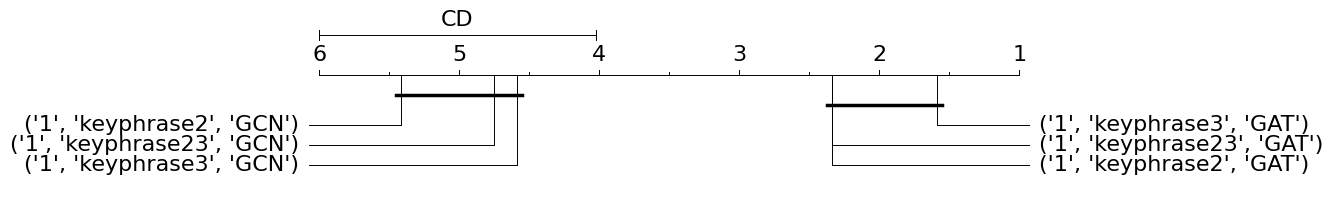

5
('5', 'keyphrase23', 'GAT') average rank: 2.3333333333333335
('5', 'keyphrase23', 'GCN') average rank: 4.583333333333333
('5', 'keyphrase2', 'GAT') average rank: 2.5
('5', 'keyphrase2', 'GCN') average rank: 5.666666666666667
('5', 'keyphrase3', 'GAT') average rank: 1.5833333333333333
('5', 'keyphrase3', 'GCN') average rank: 4.333333333333333


<ipython-input-77-401662576cf7>:21: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = compute_CD(avg_ranks, n=len(df_aux), alpha='0.1', test='nemenyi')
<ipython-input-77-401662576cf7>:24: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  graph_ranks(avg_ranks, names=algorithms_names, cd=cd, width=10, textspace=1.5, reverse=True)


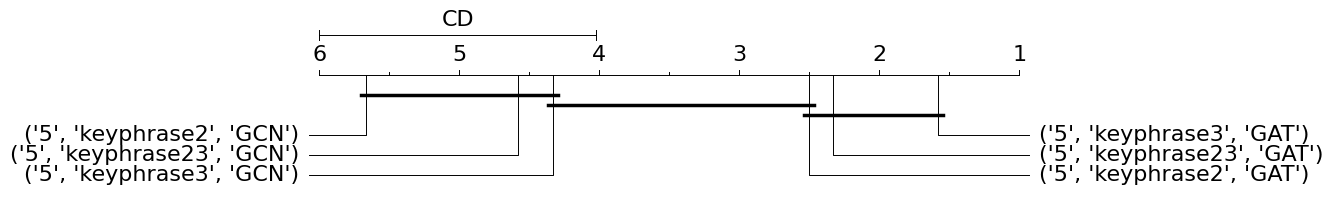

10
('10', 'keyphrase23', 'GAT') average rank: 2.5833333333333335
('10', 'keyphrase23', 'GCN') average rank: 5.166666666666667
('10', 'keyphrase2', 'GAT') average rank: 2.1666666666666665
('10', 'keyphrase2', 'GCN') average rank: 5.416666666666667
('10', 'keyphrase3', 'GAT') average rank: 1.5
('10', 'keyphrase3', 'GCN') average rank: 4.166666666666667


<ipython-input-77-401662576cf7>:21: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = compute_CD(avg_ranks, n=len(df_aux), alpha='0.1', test='nemenyi')
<ipython-input-77-401662576cf7>:24: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  graph_ranks(avg_ranks, names=algorithms_names, cd=cd, width=10, textspace=1.5, reverse=True)


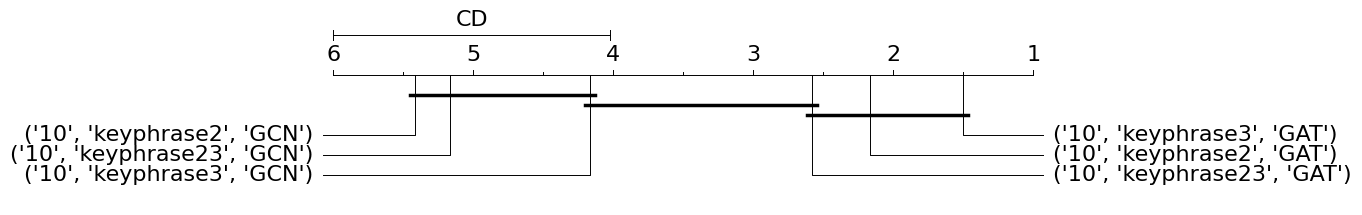

20
('20', 'keyphrase23', 'GAT') average rank: 2.1666666666666665
('20', 'keyphrase23', 'GCN') average rank: 4.5
('20', 'keyphrase2', 'GAT') average rank: 2.5
('20', 'keyphrase2', 'GCN') average rank: 5.75
('20', 'keyphrase3', 'GAT') average rank: 1.5833333333333333
('20', 'keyphrase3', 'GCN') average rank: 4.5


<ipython-input-77-401662576cf7>:21: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = compute_CD(avg_ranks, n=len(df_aux), alpha='0.1', test='nemenyi')
<ipython-input-77-401662576cf7>:24: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  graph_ranks(avg_ranks, names=algorithms_names, cd=cd, width=10, textspace=1.5, reverse=True)


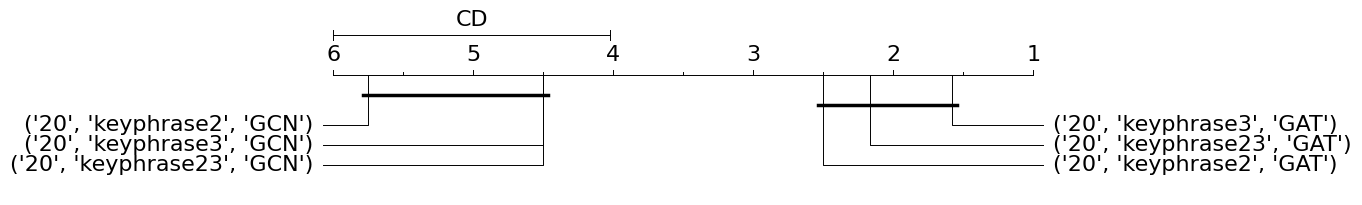

30
('30', 'keyphrase23', 'GAT') average rank: 2.125
('30', 'keyphrase23', 'GCN') average rank: 4.541666666666667
('30', 'keyphrase2', 'GAT') average rank: 2.7916666666666665
('30', 'keyphrase2', 'GCN') average rank: 5.291666666666667
('30', 'keyphrase3', 'GAT') average rank: 1.9583333333333333
('30', 'keyphrase3', 'GCN') average rank: 4.291666666666667


<ipython-input-77-401662576cf7>:21: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = compute_CD(avg_ranks, n=len(df_aux), alpha='0.1', test='nemenyi')
<ipython-input-77-401662576cf7>:24: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  graph_ranks(avg_ranks, names=algorithms_names, cd=cd, width=10, textspace=1.5, reverse=True)


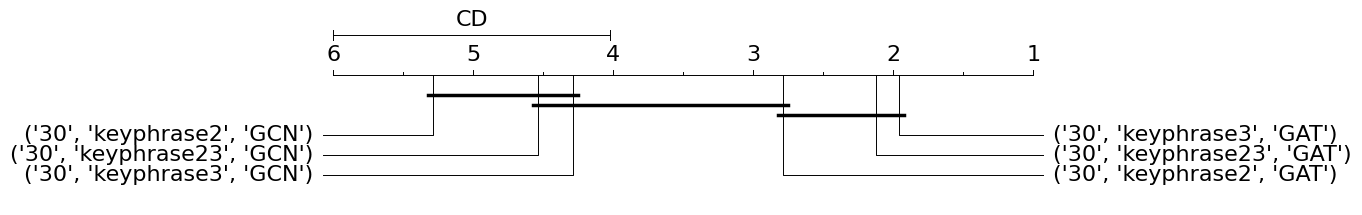

average
('average', 'keyphrase23', 'GAT') average rank: 2.0833333333333335
('average', 'keyphrase23', 'GCN') average rank: 4.666666666666667
('average', 'keyphrase2', 'GAT') average rank: 2.3333333333333335
('average', 'keyphrase2', 'GCN') average rank: 5.833333333333333
('average', 'keyphrase3', 'GAT') average rank: 1.5833333333333333
('average', 'keyphrase3', 'GCN') average rank: 4.5


<ipython-input-77-401662576cf7>:21: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = compute_CD(avg_ranks, n=len(df_aux), alpha='0.1', test='nemenyi')
<ipython-input-77-401662576cf7>:24: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  graph_ranks(avg_ranks, names=algorithms_names, cd=cd, width=10, textspace=1.5, reverse=True)


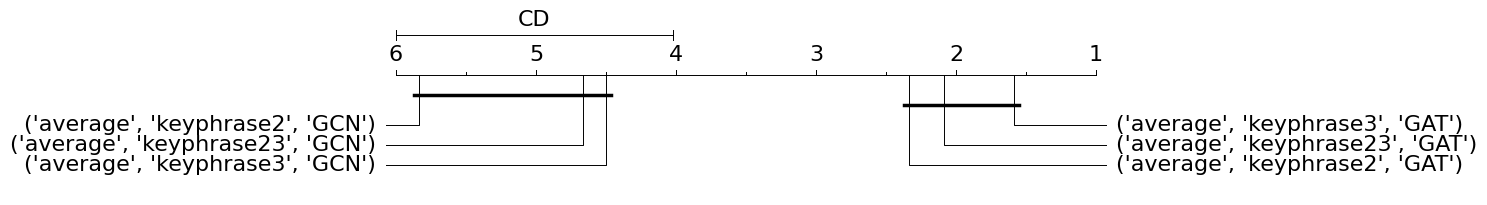

In [77]:
for nlabel in colunas:
    print(nlabel)

    columns = ['dataset']
    for col in df.columns[1:]:
        if col[0] == nlabel:
            columns.append(col)
    df_aux = df[columns]

    algorithms_names = df_aux.drop('dataset', axis=1).columns

    A = df_aux[algorithms_names].values

    friedmanchisquare(*A)

    ranks = np.array([rankdata(-p) for p in A])
    avg_ranks = np.mean(ranks, axis=0)

    print('\n'.join('{} average rank: {}'.format(a, r) for a, r in zip(algorithms_names, avg_ranks)))

    cd = compute_CD(avg_ranks, n=len(df_aux), alpha='0.1', test='nemenyi')

    # This method generates the plot.
    graph_ranks(avg_ranks, names=algorithms_names, cd=cd, width=10, textspace=1.5, reverse=True)
    plt.savefig(output_path+str(nlabel)+'.pdf', bbox_inches = "tight")
    plt.show()

    # bonferroni
    # cd = compute_CD(avg_ranks, n=len(df), alpha='0.05', test='bonferroni-dunn')

    # # This method generates the plot.
    # graph_ranks(avg_ranks, names=algorithms_names, cd=cd, cdmethod=0, width=10, textspace=1.5, reverse=True)
    # plt.show()

# LLM 50


In [78]:
# sample_size = 50
input_path ='/content/drive/MyDrive/Resultados/LLM/50/tabelas/'
output_path ='/content/drive/MyDrive/Resultados/LLM/50/tabelas/CD/'

## create dirs

In [79]:
 # cria dirrotio para keyphrase
try:
    os.makedirs(output_path)
except OSError as e:
    if e.errno != errno.EEXIST:
        raise

## load

In [80]:
df = pd.read_csv(input_path+"/mean/df_f1.csv", index_col='Dataframe')   # f1-score
df['average'] = df.mean(axis=1)

colunas = df.columns

In [81]:
colunas

Index(['LLM_only', '1', '5', '10', '20', '30', 'average'], dtype='object')

## preprocess data

In [82]:
# Renomeas os "_" dos datasets por "-"
for idx, row in df.iterrows():
    x = idx.split('_')
    if len(x)==4:
        df.rename(index={idx: x[0]+'-'+x[1]+'_'+x[2]+'_'+x[3]},inplace=True)

df.fillna(0,inplace=True)

In [83]:
x = df.index.str.split('_', expand=True)

l1,l2,l3 = [], [], []
for i in x:
    l1.append(i[0])
    l2.append(i[1])
    l3.append(i[2])

df['dataset'] = l1
df['keyphrase'] =l2
df['alg'] = l3

# df[['dataset','keyphrase','alg']]= df.index.str.split('_', expand=True)

In [84]:
df.index = df['dataset']
# df.drop(index='CSTR',axis=0, inplace=True)

In [85]:
df

,LLM_only,1,5,10,20,30,average,dataset,keyphrase,alg
dataset,,,,,,,,,,
CSTR,0.758350,0.758443,0.756125,0.743334,0.690358,0.000000,0.741322,CSTR,keyphrase23,GAT
CSTR,0.769174,0.755184,0.769293,0.768966,0.710313,0.000000,0.754586,CSTR,keyphrase23,GCN
CSTR,0.757141,0.759661,0.752502,0.744708,0.691303,0.000000,0.741063,CSTR,keyphrase2,GAT
CSTR,0.767367,0.759634,0.748860,0.747022,0.735310,0.000000,0.751639,CSTR,keyphrase2,GCN
CSTR,0.759583,0.756195,0.751310,0.738421,0.692469,0.000000,0.739596,CSTR,keyphrase3,GAT
...,...,...,...,...,...,...,...,...,...,...
webkb-parsed,0.196536,0.217598,0.209719,0.197908,0.236664,0.192806,0.208538,webkb-parsed,keyphrase23,GCN
webkb-parsed,0.314849,0.317675,0.328543,0.340937,0.356373,0.378003,0.339396,webkb-parsed,keyphrase2,GAT
webkb-parsed,0.217236,0.178661,0.229272,0.204831,0.186883,0.153981,0.195144,webkb-parsed,keyphrase2,GCN


In [86]:
dts = set(df.dataset)
l_df = [df[df.dataset == d][df.columns[0:]] for d in dts]

In [87]:
l_df = [ df_cstr.pivot(index='dataset', columns=['keyphrase','alg']) for df_cstr in l_df ]

In [88]:
l_df2 = []
for df_cstr in l_df:
    df_cstr.columns = df_cstr.columns.to_flat_index()
    df_cstr = df_cstr.reset_index()
    l_df2.append(df_cstr)

In [89]:
df = pd.concat(l_df2)

## Aply on all n_labels

LLM_only
('LLM_only', 'keyphrase23', 'GAT') average rank: 2.0833333333333335
('LLM_only', 'keyphrase23', 'GCN') average rank: 4.333333333333333
('LLM_only', 'keyphrase2', 'GAT') average rank: 3.0
('LLM_only', 'keyphrase2', 'GCN') average rank: 4.916666666666667
('LLM_only', 'keyphrase3', 'GAT') average rank: 1.8333333333333333
('LLM_only', 'keyphrase3', 'GCN') average rank: 4.833333333333333


<ipython-input-90-401662576cf7>:21: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = compute_CD(avg_ranks, n=len(df_aux), alpha='0.1', test='nemenyi')
<ipython-input-90-401662576cf7>:24: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  graph_ranks(avg_ranks, names=algorithms_names, cd=cd, width=10, textspace=1.5, reverse=True)


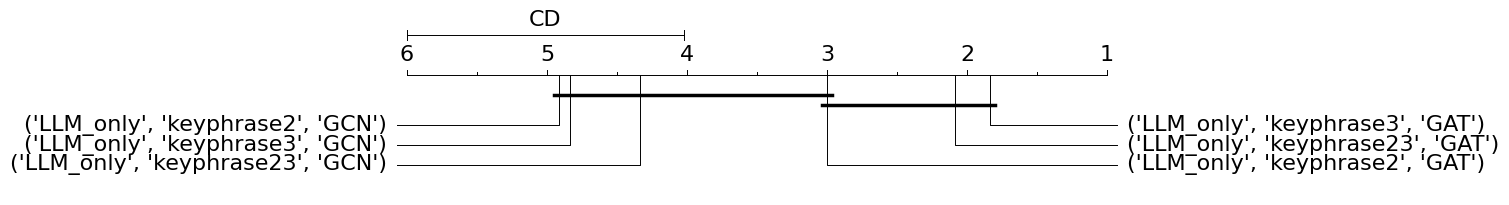

1
('1', 'keyphrase23', 'GAT') average rank: 2.25
('1', 'keyphrase23', 'GCN') average rank: 4.833333333333333
('1', 'keyphrase2', 'GAT') average rank: 2.1666666666666665
('1', 'keyphrase2', 'GCN') average rank: 5.583333333333333
('1', 'keyphrase3', 'GAT') average rank: 2.0
('1', 'keyphrase3', 'GCN') average rank: 4.166666666666667


<ipython-input-90-401662576cf7>:21: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = compute_CD(avg_ranks, n=len(df_aux), alpha='0.1', test='nemenyi')
<ipython-input-90-401662576cf7>:24: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  graph_ranks(avg_ranks, names=algorithms_names, cd=cd, width=10, textspace=1.5, reverse=True)


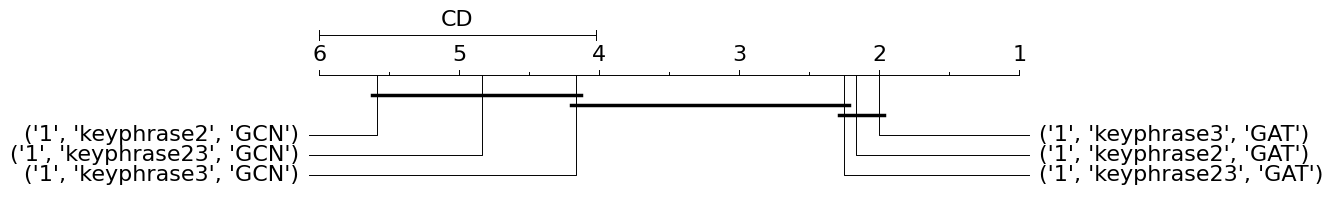

5
('5', 'keyphrase23', 'GAT') average rank: 2.6666666666666665
('5', 'keyphrase23', 'GCN') average rank: 4.25
('5', 'keyphrase2', 'GAT') average rank: 2.6666666666666665
('5', 'keyphrase2', 'GCN') average rank: 5.333333333333333
('5', 'keyphrase3', 'GAT') average rank: 1.5833333333333333
('5', 'keyphrase3', 'GCN') average rank: 4.5


<ipython-input-90-401662576cf7>:21: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = compute_CD(avg_ranks, n=len(df_aux), alpha='0.1', test='nemenyi')
<ipython-input-90-401662576cf7>:24: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  graph_ranks(avg_ranks, names=algorithms_names, cd=cd, width=10, textspace=1.5, reverse=True)


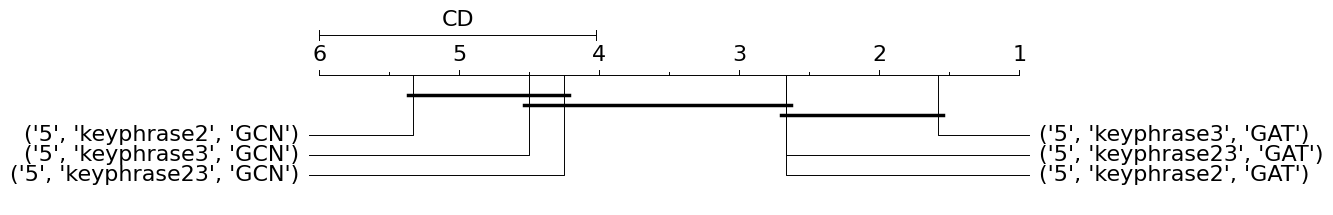

10
('10', 'keyphrase23', 'GAT') average rank: 2.75
('10', 'keyphrase23', 'GCN') average rank: 4.833333333333333
('10', 'keyphrase2', 'GAT') average rank: 2.5
('10', 'keyphrase2', 'GCN') average rank: 5.0
('10', 'keyphrase3', 'GAT') average rank: 2.1666666666666665
('10', 'keyphrase3', 'GCN') average rank: 3.75


<ipython-input-90-401662576cf7>:21: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = compute_CD(avg_ranks, n=len(df_aux), alpha='0.1', test='nemenyi')
<ipython-input-90-401662576cf7>:24: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  graph_ranks(avg_ranks, names=algorithms_names, cd=cd, width=10, textspace=1.5, reverse=True)


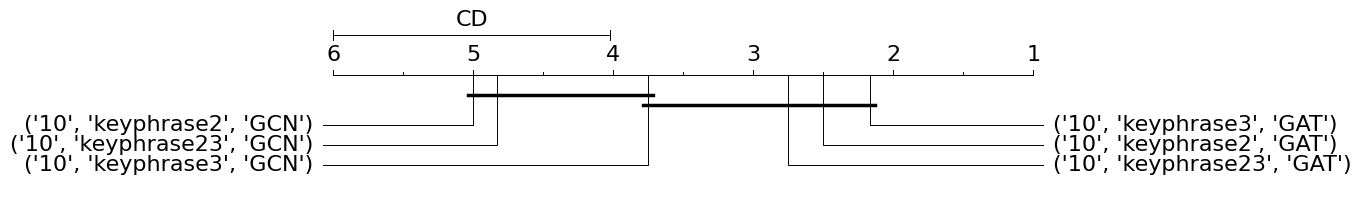

20
('20', 'keyphrase23', 'GAT') average rank: 2.9166666666666665
('20', 'keyphrase23', 'GCN') average rank: 4.416666666666667
('20', 'keyphrase2', 'GAT') average rank: 2.6666666666666665
('20', 'keyphrase2', 'GCN') average rank: 5.166666666666667
('20', 'keyphrase3', 'GAT') average rank: 1.9166666666666667
('20', 'keyphrase3', 'GCN') average rank: 3.9166666666666665


<ipython-input-90-401662576cf7>:21: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = compute_CD(avg_ranks, n=len(df_aux), alpha='0.1', test='nemenyi')
<ipython-input-90-401662576cf7>:24: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  graph_ranks(avg_ranks, names=algorithms_names, cd=cd, width=10, textspace=1.5, reverse=True)


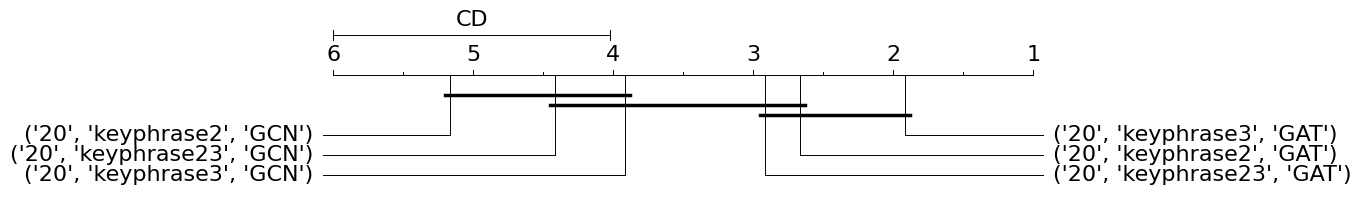

30
('30', 'keyphrase23', 'GAT') average rank: 1.875
('30', 'keyphrase23', 'GCN') average rank: 4.375
('30', 'keyphrase2', 'GAT') average rank: 3.125
('30', 'keyphrase2', 'GCN') average rank: 5.041666666666667
('30', 'keyphrase3', 'GAT') average rank: 1.875
('30', 'keyphrase3', 'GCN') average rank: 4.708333333333333


<ipython-input-90-401662576cf7>:21: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = compute_CD(avg_ranks, n=len(df_aux), alpha='0.1', test='nemenyi')
<ipython-input-90-401662576cf7>:24: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  graph_ranks(avg_ranks, names=algorithms_names, cd=cd, width=10, textspace=1.5, reverse=True)


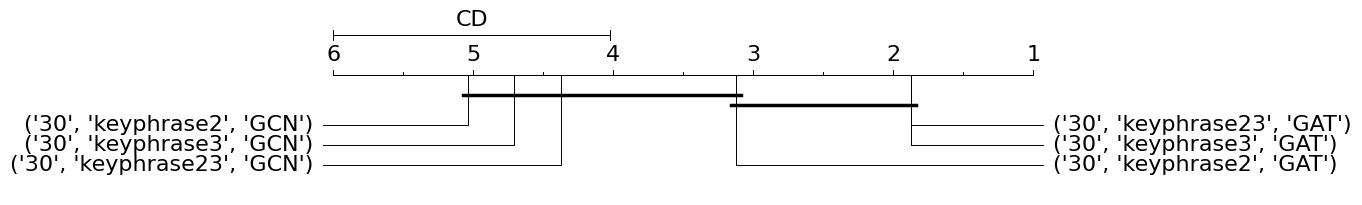

average
('average', 'keyphrase23', 'GAT') average rank: 2.5
('average', 'keyphrase23', 'GCN') average rank: 4.166666666666667
('average', 'keyphrase2', 'GAT') average rank: 3.0833333333333335
('average', 'keyphrase2', 'GCN') average rank: 5.25
('average', 'keyphrase3', 'GAT') average rank: 1.9166666666666667
('average', 'keyphrase3', 'GCN') average rank: 4.083333333333333


<ipython-input-90-401662576cf7>:21: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = compute_CD(avg_ranks, n=len(df_aux), alpha='0.1', test='nemenyi')
<ipython-input-90-401662576cf7>:24: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  graph_ranks(avg_ranks, names=algorithms_names, cd=cd, width=10, textspace=1.5, reverse=True)


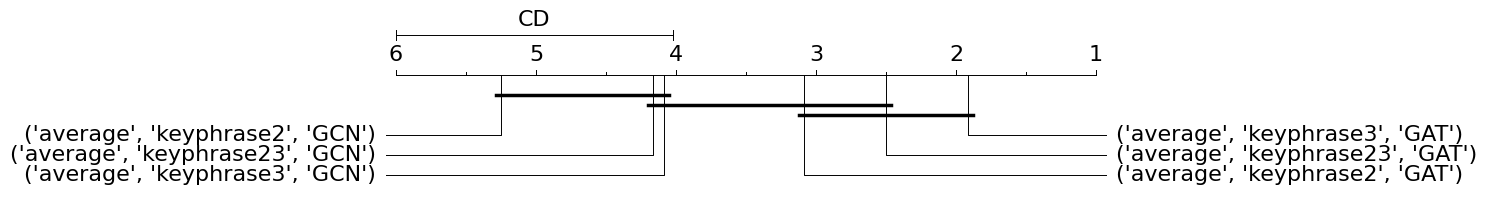

In [90]:
for nlabel in colunas:
    print(nlabel)

    columns = ['dataset']
    for col in df.columns[1:]:
        if col[0] == nlabel:
            columns.append(col)
    df_aux = df[columns]

    algorithms_names = df_aux.drop('dataset', axis=1).columns

    A = df_aux[algorithms_names].values

    friedmanchisquare(*A)

    ranks = np.array([rankdata(-p) for p in A])
    avg_ranks = np.mean(ranks, axis=0)

    print('\n'.join('{} average rank: {}'.format(a, r) for a, r in zip(algorithms_names, avg_ranks)))

    cd = compute_CD(avg_ranks, n=len(df_aux), alpha='0.1', test='nemenyi')

    # This method generates the plot.
    graph_ranks(avg_ranks, names=algorithms_names, cd=cd, width=10, textspace=1.5, reverse=True)
    plt.savefig(output_path+str(nlabel)+'.pdf', bbox_inches = "tight")
    plt.show()

    # bonferroni
    # cd = compute_CD(avg_ranks, n=len(df), alpha='0.05', test='bonferroni-dunn')

    # # This method generates the plot.
    # graph_ranks(avg_ranks, names=algorithms_names, cd=cd, cdmethod=0, width=10, textspace=1.5, reverse=True)
    # plt.show()

# LLM 100


In [91]:
# sample_size = 100
input_path ='/content/drive/MyDrive/Resultados/LLM/100/tabelas/'
output_path ='/content/drive/MyDrive/Resultados/LLM/100/tabelas/CD/'

## create dirs

In [92]:
 # cria dirrotio para keyphrase
try:
    os.makedirs(output_path)
except OSError as e:
    if e.errno != errno.EEXIST:
        raise

## load

In [93]:
df = pd.read_csv(input_path+"/mean/df_f1.csv", index_col='Dataframe')   # f1-score
df['average'] = df.mean(axis=1)

colunas = df.columns

In [94]:
colunas

Index(['LLM_only', '1', '5', '10', '20', '30', 'average'], dtype='object')

## preprocess data

In [95]:
# Renomeas os "_" dos datasets por "-"
for idx, row in df.iterrows():
    x = idx.split('_')
    if len(x)==4:
        df.rename(index={idx: x[0]+'-'+x[1]+'_'+x[2]+'_'+x[3]},inplace=True)

df.fillna(0,inplace=True)

In [96]:
x = df.index.str.split('_', expand=True)

l1,l2,l3 = [], [], []
for i in x:
    l1.append(i[0])
    l2.append(i[1])
    l3.append(i[2])

df['dataset'] = l1
df['keyphrase'] =l2
df['alg'] = l3

# df[['dataset','keyphrase','alg']]= df.index.str.split('_', expand=True)

In [97]:
df.index = df['dataset']
# df.drop(index='CSTR',axis=0, inplace=True)

In [98]:
df

,LLM_only,1,5,10,20,30,average,dataset,keyphrase,alg
dataset,,,,,,,,,,
CSTR,0.767105,0.767725,0.757832,0.739542,0.688404,0.000000,0.744122,CSTR,keyphrase23,GAT
CSTR,0.797674,0.791466,0.790620,0.767166,0.726069,0.000000,0.774599,CSTR,keyphrase23,GCN
CSTR,0.765083,0.762555,0.758589,0.741914,0.691416,0.000000,0.743911,CSTR,keyphrase2,GAT
CSTR,0.791623,0.753096,0.736540,0.762996,0.706712,0.000000,0.750194,CSTR,keyphrase2,GCN
CSTR,0.769925,0.771571,0.758928,0.737241,0.690936,0.000000,0.745720,CSTR,keyphrase3,GAT
...,...,...,...,...,...,...,...,...,...,...
webkb-parsed,0.221146,0.210261,0.195682,0.184165,0.177782,0.191337,0.196729,webkb-parsed,keyphrase23,GCN
webkb-parsed,0.336501,0.336868,0.344702,0.342129,0.345167,0.351461,0.342805,webkb-parsed,keyphrase2,GAT
webkb-parsed,0.198643,0.153995,0.171292,0.177846,0.138793,0.146488,0.164509,webkb-parsed,keyphrase2,GCN


In [99]:
dts = set(df.dataset)
l_df = [df[df.dataset == d][df.columns[0:]] for d in dts]

In [100]:
l_df = [ df_cstr.pivot(index='dataset', columns=['keyphrase','alg']) for df_cstr in l_df ]

In [101]:
l_df2 = []
for df_cstr in l_df:
    df_cstr.columns = df_cstr.columns.to_flat_index()
    df_cstr = df_cstr.reset_index()
    l_df2.append(df_cstr)

In [102]:
df = pd.concat(l_df2)

## Aply on all n_labels

LLM_only
('LLM_only', 'keyphrase23', 'GAT') average rank: 2.4166666666666665
('LLM_only', 'keyphrase23', 'GCN') average rank: 4.5
('LLM_only', 'keyphrase2', 'GAT') average rank: 3.1666666666666665
('LLM_only', 'keyphrase2', 'GCN') average rank: 5.083333333333333
('LLM_only', 'keyphrase3', 'GAT') average rank: 1.9166666666666667
('LLM_only', 'keyphrase3', 'GCN') average rank: 3.9166666666666665


<ipython-input-103-401662576cf7>:21: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = compute_CD(avg_ranks, n=len(df_aux), alpha='0.1', test='nemenyi')
<ipython-input-103-401662576cf7>:24: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  graph_ranks(avg_ranks, names=algorithms_names, cd=cd, width=10, textspace=1.5, reverse=True)


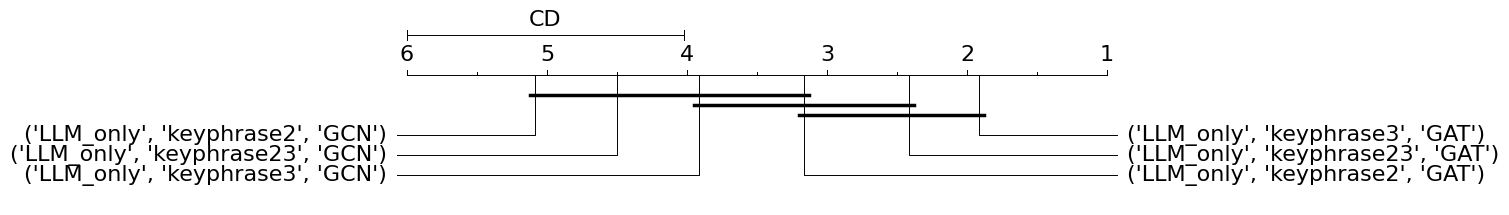

1
('1', 'keyphrase23', 'GAT') average rank: 2.25
('1', 'keyphrase23', 'GCN') average rank: 4.083333333333333
('1', 'keyphrase2', 'GAT') average rank: 2.9166666666666665
('1', 'keyphrase2', 'GCN') average rank: 5.5
('1', 'keyphrase3', 'GAT') average rank: 2.0
('1', 'keyphrase3', 'GCN') average rank: 4.25


<ipython-input-103-401662576cf7>:21: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = compute_CD(avg_ranks, n=len(df_aux), alpha='0.1', test='nemenyi')
<ipython-input-103-401662576cf7>:24: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  graph_ranks(avg_ranks, names=algorithms_names, cd=cd, width=10, textspace=1.5, reverse=True)


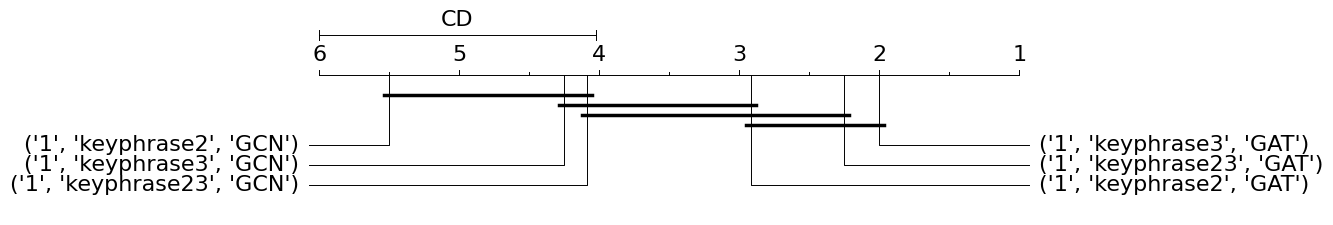

5
('5', 'keyphrase23', 'GAT') average rank: 2.5833333333333335
('5', 'keyphrase23', 'GCN') average rank: 4.166666666666667
('5', 'keyphrase2', 'GAT') average rank: 2.75
('5', 'keyphrase2', 'GCN') average rank: 5.25
('5', 'keyphrase3', 'GAT') average rank: 1.9166666666666667
('5', 'keyphrase3', 'GCN') average rank: 4.333333333333333


<ipython-input-103-401662576cf7>:21: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = compute_CD(avg_ranks, n=len(df_aux), alpha='0.1', test='nemenyi')
<ipython-input-103-401662576cf7>:24: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  graph_ranks(avg_ranks, names=algorithms_names, cd=cd, width=10, textspace=1.5, reverse=True)


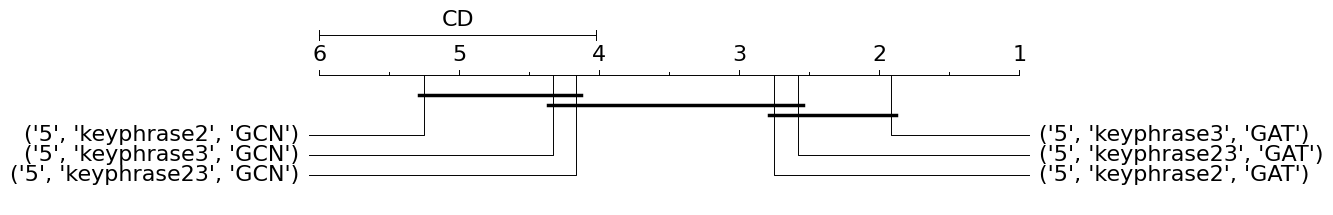

10
('10', 'keyphrase23', 'GAT') average rank: 2.9166666666666665
('10', 'keyphrase23', 'GCN') average rank: 4.5
('10', 'keyphrase2', 'GAT') average rank: 2.8333333333333335
('10', 'keyphrase2', 'GCN') average rank: 5.083333333333333
('10', 'keyphrase3', 'GAT') average rank: 1.75
('10', 'keyphrase3', 'GCN') average rank: 3.9166666666666665


<ipython-input-103-401662576cf7>:21: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = compute_CD(avg_ranks, n=len(df_aux), alpha='0.1', test='nemenyi')
<ipython-input-103-401662576cf7>:24: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  graph_ranks(avg_ranks, names=algorithms_names, cd=cd, width=10, textspace=1.5, reverse=True)


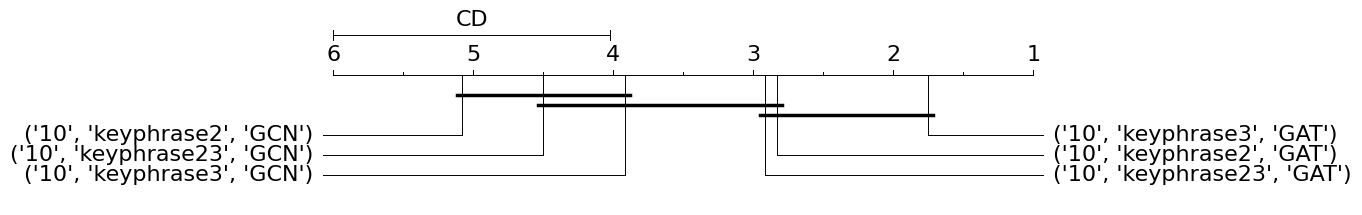

20
('20', 'keyphrase23', 'GAT') average rank: 2.4166666666666665
('20', 'keyphrase23', 'GCN') average rank: 4.583333333333333
('20', 'keyphrase2', 'GAT') average rank: 2.8333333333333335
('20', 'keyphrase2', 'GCN') average rank: 5.083333333333333
('20', 'keyphrase3', 'GAT') average rank: 2.0833333333333335
('20', 'keyphrase3', 'GCN') average rank: 4.0


<ipython-input-103-401662576cf7>:21: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = compute_CD(avg_ranks, n=len(df_aux), alpha='0.1', test='nemenyi')
<ipython-input-103-401662576cf7>:24: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  graph_ranks(avg_ranks, names=algorithms_names, cd=cd, width=10, textspace=1.5, reverse=True)


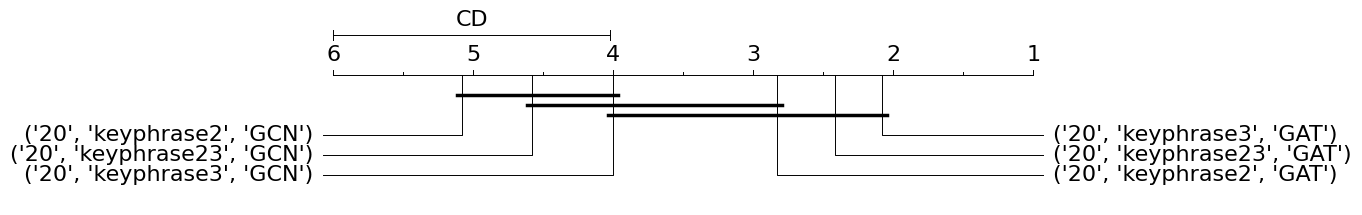

30
('30', 'keyphrase23', 'GAT') average rank: 2.125
('30', 'keyphrase23', 'GCN') average rank: 4.708333333333333
('30', 'keyphrase2', 'GAT') average rank: 2.9583333333333335
('30', 'keyphrase2', 'GCN') average rank: 5.125
('30', 'keyphrase3', 'GAT') average rank: 2.0416666666666665
('30', 'keyphrase3', 'GCN') average rank: 4.041666666666667


<ipython-input-103-401662576cf7>:21: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = compute_CD(avg_ranks, n=len(df_aux), alpha='0.1', test='nemenyi')
<ipython-input-103-401662576cf7>:24: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  graph_ranks(avg_ranks, names=algorithms_names, cd=cd, width=10, textspace=1.5, reverse=True)


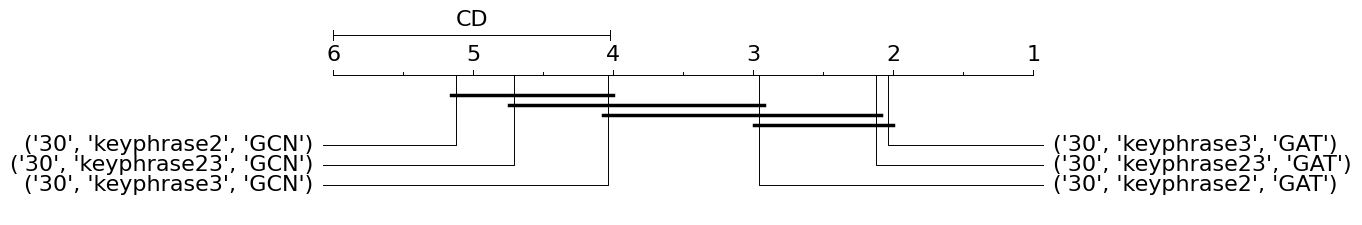

average
('average', 'keyphrase23', 'GAT') average rank: 2.5
('average', 'keyphrase23', 'GCN') average rank: 4.583333333333333
('average', 'keyphrase2', 'GAT') average rank: 3.0833333333333335
('average', 'keyphrase2', 'GCN') average rank: 5.0
('average', 'keyphrase3', 'GAT') average rank: 1.9166666666666667
('average', 'keyphrase3', 'GCN') average rank: 3.9166666666666665


<ipython-input-103-401662576cf7>:21: OrangeDeprecationWarning: compute_CD is deprecated and will be removed in Orange 3.34.
  cd = compute_CD(avg_ranks, n=len(df_aux), alpha='0.1', test='nemenyi')
<ipython-input-103-401662576cf7>:24: OrangeDeprecationWarning: graph_ranks is deprecated and will be removed in Orange 3.34.
  graph_ranks(avg_ranks, names=algorithms_names, cd=cd, width=10, textspace=1.5, reverse=True)


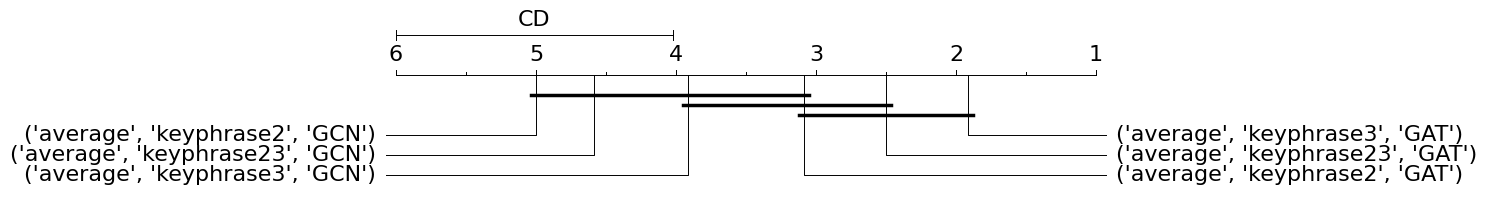

In [103]:
for nlabel in colunas:
    print(nlabel)

    columns = ['dataset']
    for col in df.columns[1:]:
        if col[0] == nlabel:
            columns.append(col)
    df_aux = df[columns]

    algorithms_names = df_aux.drop('dataset', axis=1).columns

    A = df_aux[algorithms_names].values

    friedmanchisquare(*A)

    ranks = np.array([rankdata(-p) for p in A])
    avg_ranks = np.mean(ranks, axis=0)

    print('\n'.join('{} average rank: {}'.format(a, r) for a, r in zip(algorithms_names, avg_ranks)))

    cd = compute_CD(avg_ranks, n=len(df_aux), alpha='0.1', test='nemenyi')

    # This method generates the plot.
    graph_ranks(avg_ranks, names=algorithms_names, cd=cd, width=10, textspace=1.5, reverse=True)
    plt.savefig(output_path+str(nlabel)+'.pdf', bbox_inches = "tight")
    plt.show()

    # bonferroni
    # cd = compute_CD(avg_ranks, n=len(df), alpha='0.05', test='bonferroni-dunn')

    # # This method generates the plot.
    # graph_ranks(avg_ranks, names=algorithms_names, cd=cd, cdmethod=0, width=10, textspace=1.5, reverse=True)
    # plt.show()